In [2]:
import pandas as pd
import requests
from io import StringIO
import os
from dotenv import load_dotenv
import matplotlib.pyplot  as plt
import seaborn as sns
from datetime import date
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN



In [3]:
load_dotenv()

True

# Lectura y Preparación

In [4]:

#
myurl = os.environ["DETALLE_TAREAS_FULL_URL"] + "?" + os.environ["AZURE_DATALAKE_GENAI_TOKEN"]
df = pd.read_parquet(myurl)
#df = pd.read_parquet("data\\DETALLE_TAREAS_COMPLETO.parquet")
#df


In [5]:
df["FECHA_CIERRE"]=pd.to_datetime(df.FECHA_CIERRE,yearfirst=True,dayfirst=True)
df["DIA_SEMANA"]=df.FECHA_CIERRE.dt.day_of_week+1
df["DIA_SEMANA_NOM"]=df.FECHA_CIERRE.dt.day_name()
df["DIA_MES"]=df.FECHA_CIERRE.dt.days_in_month
df


FECHA_CIERRE CODIGO_TAREA      DESCRIPCION_TAREA              INICIO  \
0       2024-07-29     PX999C17  Depuracion del FSC017 2024-07-30 03:26:09   
1       2024-07-30     PX999C17  Depuracion del FSC017 2024-07-31 06:14:17   
2       2024-07-31     PX999C17  Depuracion del FSC017 2024-08-01 10:46:43   
3       2024-08-01     PX999C17  Depuracion del FSC017 2024-08-02 03:00:51   
4       2024-08-02     PX999C17  Depuracion del FSC017 2024-08-03 02:24:15   
...            ...          ...                    ...                 ...   
12490   2024-11-20    PCSMI001B        Rendicion Batch 2024-11-21 02:26:39   
12491   2024-11-21    PCSMI001B        Rendicion Batch 2024-11-22 02:26:45   
12492   2024-11-22    PCSMI001B        Rendicion Batch 2024-11-23 02:19:06   
12493   2024-11-23    PCSMI001B        Rendicion Batch 2024-11-24 01:42:33   
12494   2024-11-25    PCSMI001B        Rendicion Batch 2024-11-26 03:04:56   

                      FIN  DURACION_SEGUNDOS  DURACION  DIA_SEMANA  \
0     2024-07-30 03:26:10                1.0  00:00:01           1   
1     2024-07-31 06:14:18                1.0  00:00:01           2   
2     2024-08-01 10:46:44                1.0  00:00:01           3   
3     2024-08-02 03:00:52                1.0  00:00:01           4   
4     2024-08-03 02:24:16                1.0  00:00:01           5   
...                   ...                ...       ...         ...   
12490 2024-11-21 02:26:40                1.0  00:00:01           3   
12491 2024-11-22 02:26:46                1.0  00:00:01           4   
12492 2024-11-23 02:19:07                1.0  00:00:01           5   
12493 2024-11-24 01:42:34                1.0  00:00:01           6   
12494 2024-11-26 03:04:57                1.0  00:00:01           1   

      DIA_SEMANA_NOM  DIA_MES  
0             Monday       31  
1            Tuesday       31  
2          Wednesday       31  
3           Thursday       31  
4             Friday       31  
...              ...      ...  
12490      Wednesday       30  
12491       Thursday       30  
12492         Friday       30  
12493       Saturday       30  
12494         Monday       30  

[12495 rows x 10 columns]

In [6]:
post_festivos=[
    date(2024,8,8)
    ,date(2024,8,20)
    ,date(2024,10,15)
    ,date(2024,11,5)
    ,date(2024,11,12)    
    ]

df["POST_FESTIVO"]=df.FECHA_CIERRE.isin(post_festivos)


C:\Users\juanm\AppData\Local\Temp\ipykernel_18844\1663451165.py:9: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df["POST_FESTIVO"]=df.FECHA_CIERRE.isin(post_festivos)


In [7]:
df["ID_TAREA"]=df.CODIGO_TAREA+"-"+df.DESCRIPCION_TAREA
df["DURACION_MIN"]=(df.DURACION_SEGUNDOS/60).round(0)
df["DURACION_HR"]=df.DURACION_SEGUNDOS/60/60
df["PAUSA"]=df.CODIGO_TAREA=="PAUSA"

In [8]:
df["PAUSA"].value_counts()


PAUSA
False    12000
True       495
Name: count, dtype: int64

# Análisis

## Duración total

### Distribución

In [9]:
df.groupby(["FECHA_CIERRE"], as_index=False,)["DURACION_MIN"].agg(["max","min","mean","median","sum"]	).sort_values("sum",ascending=False)

FECHA_CIERRE    max  min      mean  median    sum
2    2024-07-31  111.0  0.0  4.762500     1.0  762.0
7    2024-08-06  180.0  0.0  4.559055     0.0  579.0
58   2024-10-07  106.0  0.0  4.285714     0.0  540.0
81   2024-11-05  110.0  0.0  4.095238     0.0  516.0
52   2024-09-30   63.0  0.0  3.037736     0.0  483.0
..          ...    ...  ...       ...     ...    ...
77   2024-10-30   39.0  0.0  2.484127     0.0  313.0
51   2024-09-28   37.0  0.0  2.440945     0.0  310.0
85   2024-11-09   29.0  0.0  2.373016     0.0  299.0
89   2024-11-15   31.0  0.0  2.365079     0.0  298.0
0    2024-07-29   35.0  0.0  2.358025     0.0  191.0

[98 rows x 6 columns]

array([[<Axes: title={'center': 'sum'}>]], dtype=object)

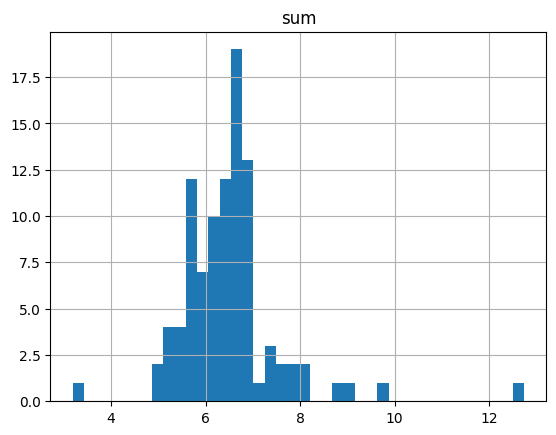

In [10]:
df.groupby(["FECHA_CIERRE"], )["DURACION_HR"].agg(["sum"]	).hist(bins=40)

<Axes: >

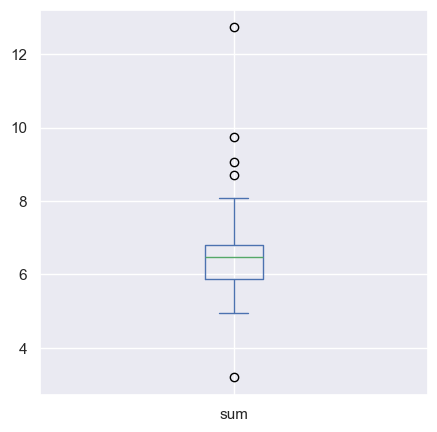

In [11]:
sns.set_theme(rc={'figure.figsize':(5,5)})
df.groupby(["FECHA_CIERRE"], )["DURACION_HR"].agg(["sum"]	).plot.box()

<Axes: xlabel='FECHA_CIERRE'>

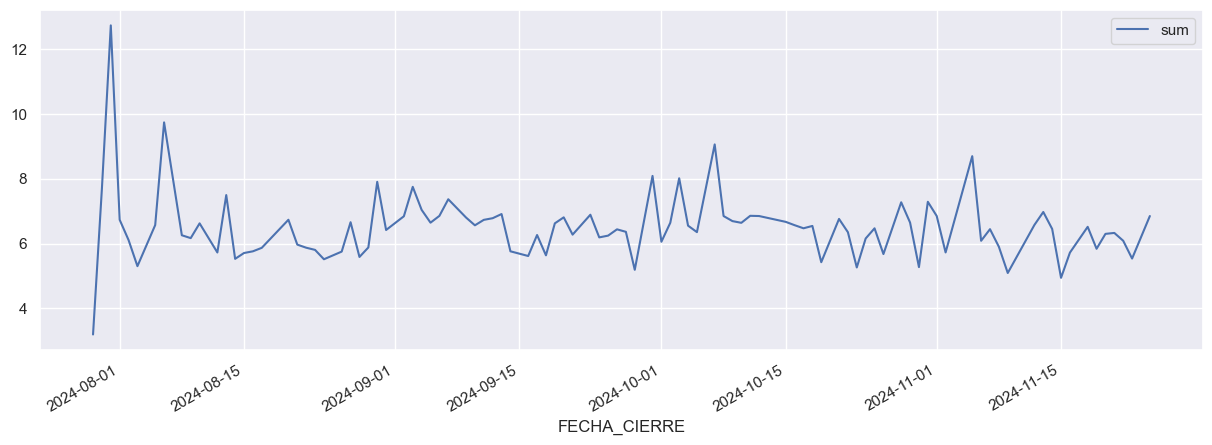

In [12]:
sns.set_theme(rc={'figure.figsize':(15,5)})
df.groupby(["FECHA_CIERRE"], )["DURACION_HR"].agg(["sum"]	).plot()

Conclusion. Distribución de cola derecha con valores extremos (anomalias) por encima de 500

<Axes: >

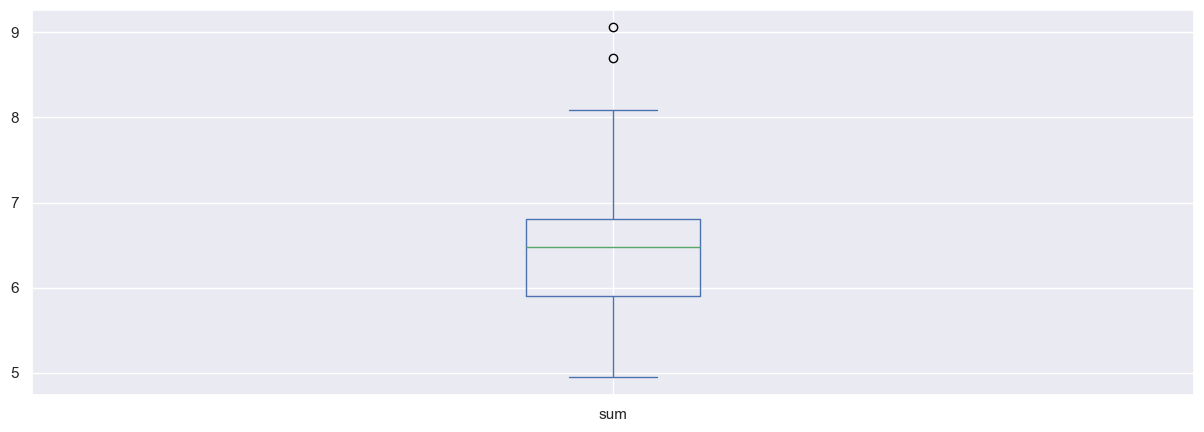

In [13]:
df_parcial=df.query("FECHA_CIERRE >= '2024-08-20'").copy()
df_parcial.groupby(["FECHA_CIERRE"], )["DURACION_HR"].agg(["sum"]	).plot.box()

## Pausas

In [14]:
df_sum=df_parcial.groupby("FECHA_CIERRE", as_index=True)["DURACION_MIN"].agg(["max","sum"])
df_sum.rename(columns={"max":"TAREA_MAX","sum":"TOTAL"}, inplace=True)
df_sum_pausas=df_parcial[df_parcial.PAUSA].groupby("FECHA_CIERRE", as_index=False)["DURACION_MIN"].sum()
df_sum_pausas.set_index("FECHA_CIERRE", inplace=True)
df_sum_pausas.rename(columns={"DURACION_MIN":"DURACION_PAUSAS"},inplace=True)
df_sum=df_sum.join(df_sum_pausas,)
df_sum["SIN_PAUSA"]=df_sum.TOTAL - df_sum.DURACION_PAUSAS


<Axes: xlabel='FECHA_CIERRE'>

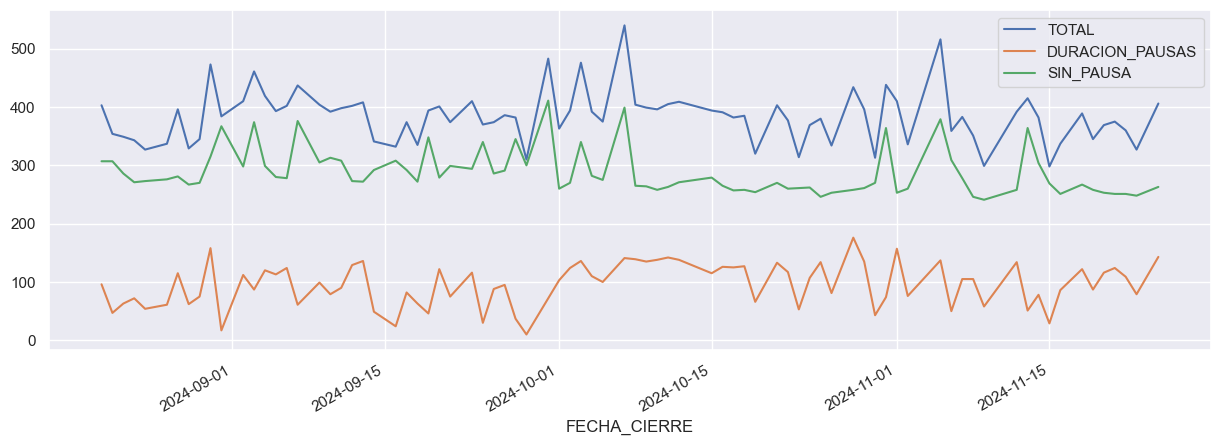

In [15]:
df_sum[['TOTAL','DURACION_PAUSAS','SIN_PAUSA']].plot(subplots=False)

Los datos antes del mes 9 tienen picos y no todos estaban asociados a pausas

<Axes: xlabel='FECHA_CIERRE'>

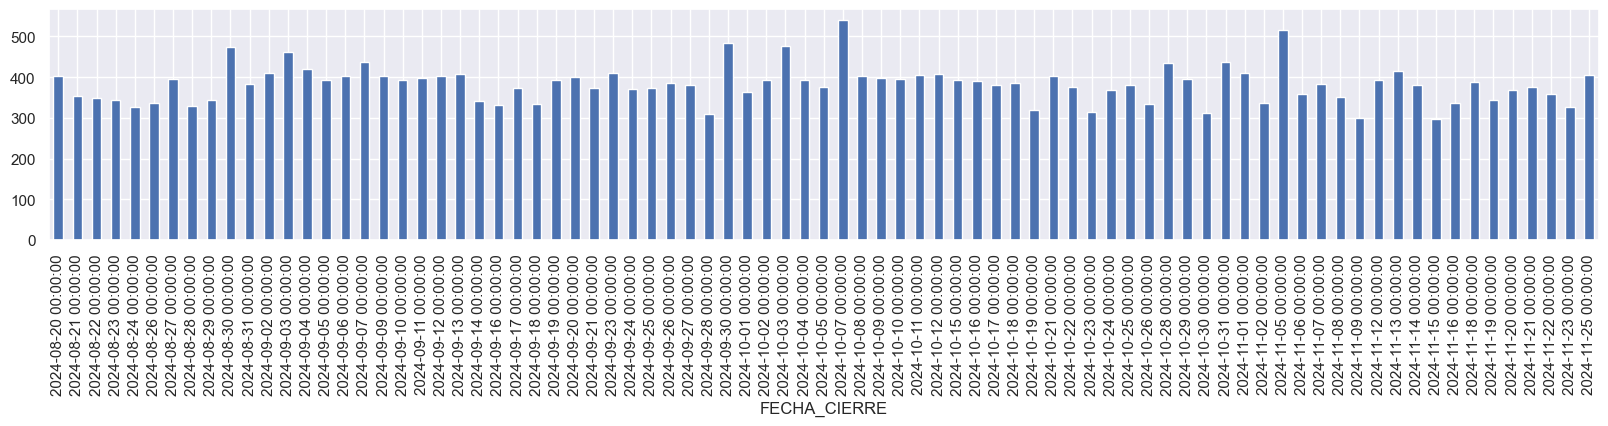

In [16]:
sns.set_theme(rc={'figure.figsize':(20,3)})
df_sum.query("index >= '2024-08-15' ")["TOTAL"].plot.bar()

<Axes: xlabel='FECHA_CIERRE'>

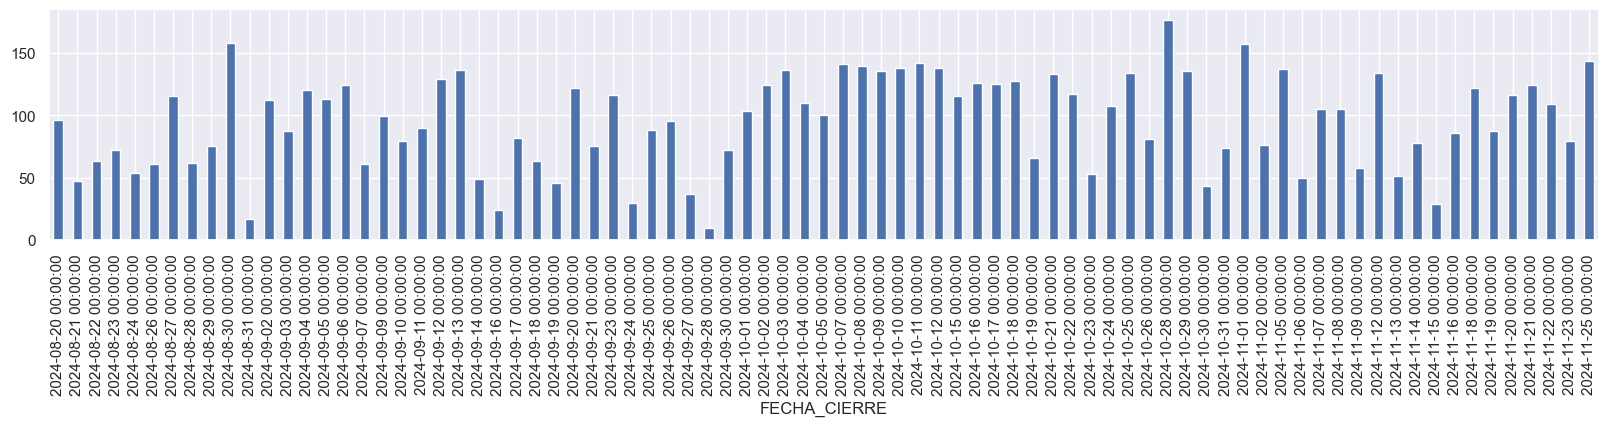

In [17]:
df_sum["DURACION_PAUSAS"].plot.bar()


<Axes: >

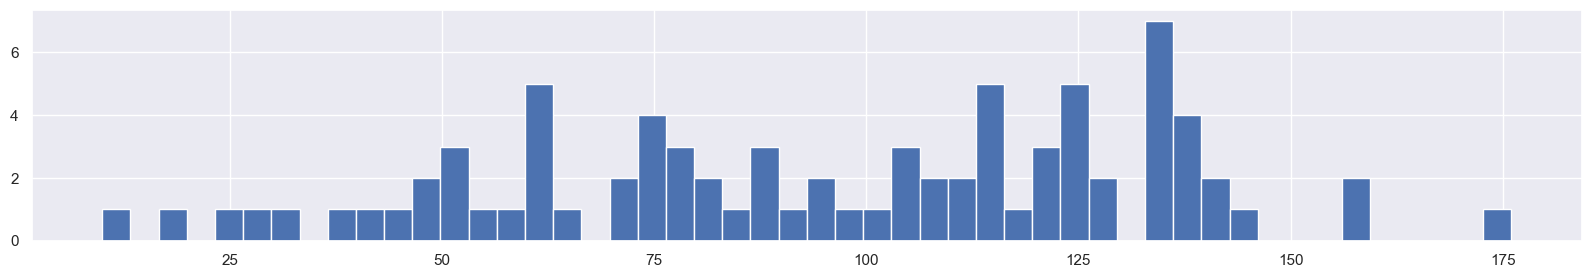

In [18]:
df_sum["DURACION_PAUSAS"].hist(bins=50)

<Axes: xlabel='FECHA_CIERRE'>

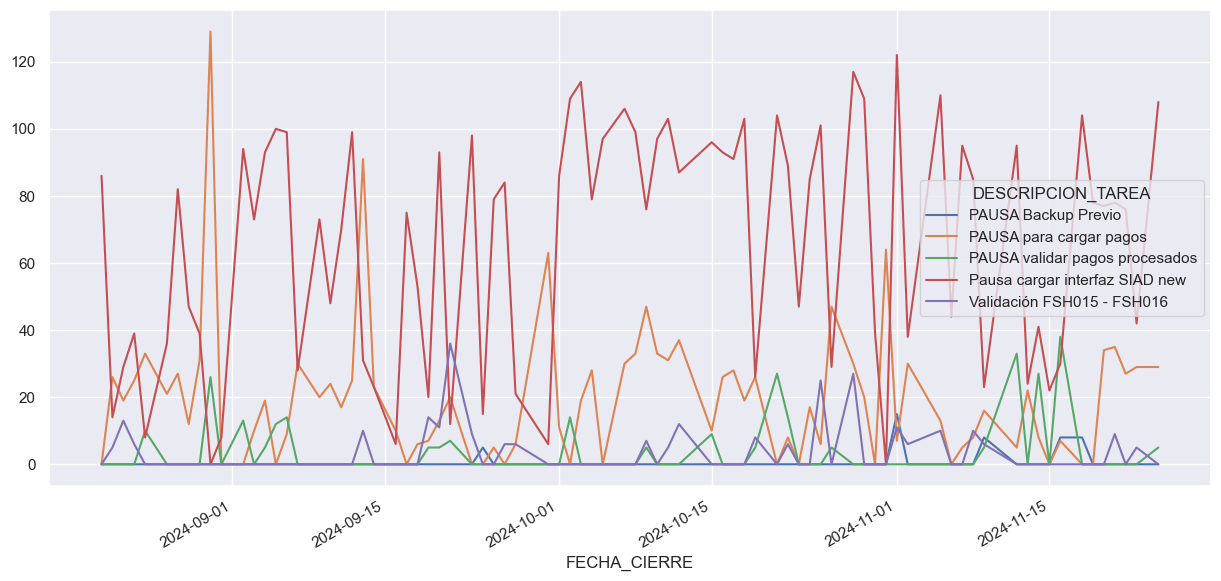

In [19]:
sns.set_theme(rc={'figure.figsize':(15,7)})
df_pausas=df_parcial[df_parcial["CODIGO_TAREA"]=="PAUSA"].groupby(["FECHA_CIERRE","DESCRIPCION_TAREA"],as_index=False)[["DESCRIPCION_TAREA","DURACION_MIN"]].max().query("DURACION_MIN > 4")

pd.crosstab(df_pausas["FECHA_CIERRE"] ,columns=df_pausas["DESCRIPCION_TAREA"], values=df_pausas["DURACION_MIN"],aggfunc="sum").fillna(0).plot()


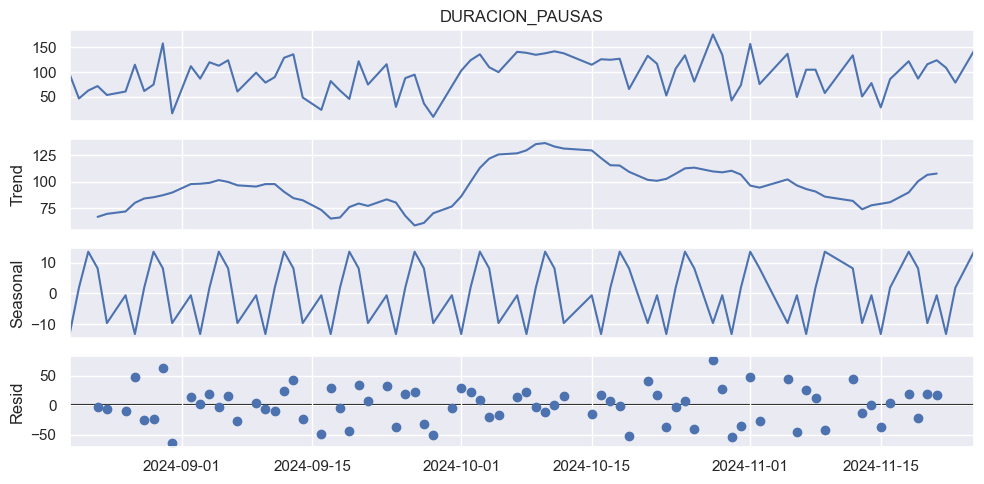

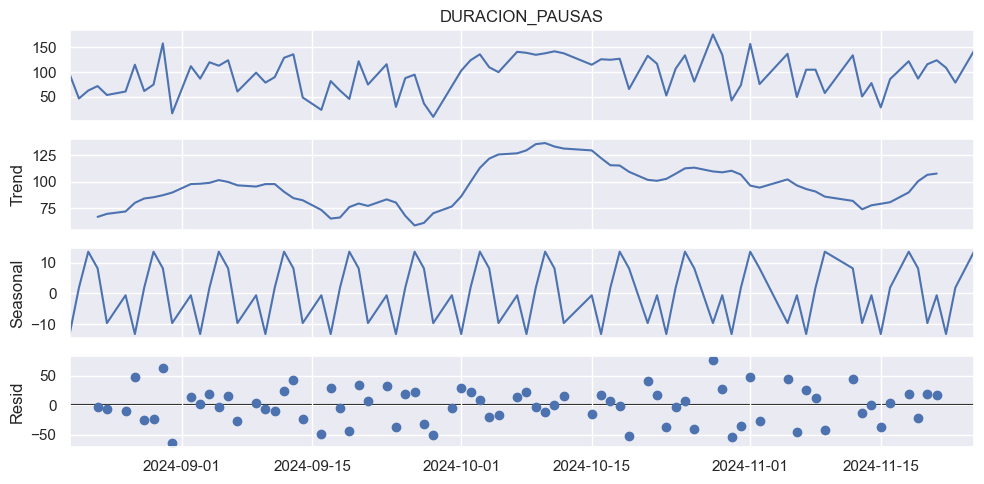

In [20]:
from statsmodels.tsa.seasonal import seasonal_decompose
sns.set_theme(rc={'figure.figsize':(10,5)})
decompose_result_mult = seasonal_decompose(df_sum["DURACION_PAUSAS"], model="additive", period=6)

decompose_result_mult.plot()

In [21]:
df_sum["FECHA"]=df_sum.index
df_sum["POST_FESTIVO"]=df_sum.FECHA.isin(post_festivos)

C:\Users\juanm\AppData\Local\Temp\ipykernel_18844\3062257077.py:2: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df_sum["POST_FESTIVO"]=df_sum.FECHA.isin(post_festivos)


In [22]:
df_sum[df_sum["POST_FESTIVO"]]

TAREA_MAX  TOTAL  DURACION_PAUSAS  SIN_PAUSA      FECHA  \
FECHA_CIERRE                                                            
2024-08-20         86.0  403.0             96.0      307.0 2024-08-20   
2024-10-15         96.0  394.0            115.0      279.0 2024-10-15   
2024-11-05        110.0  516.0            137.0      379.0 2024-11-05   
2024-11-12         95.0  392.0            134.0      258.0 2024-11-12   

              POST_FESTIVO  
FECHA_CIERRE                
2024-08-20            True  
2024-10-15            True  
2024-11-05            True  
2024-11-12            True

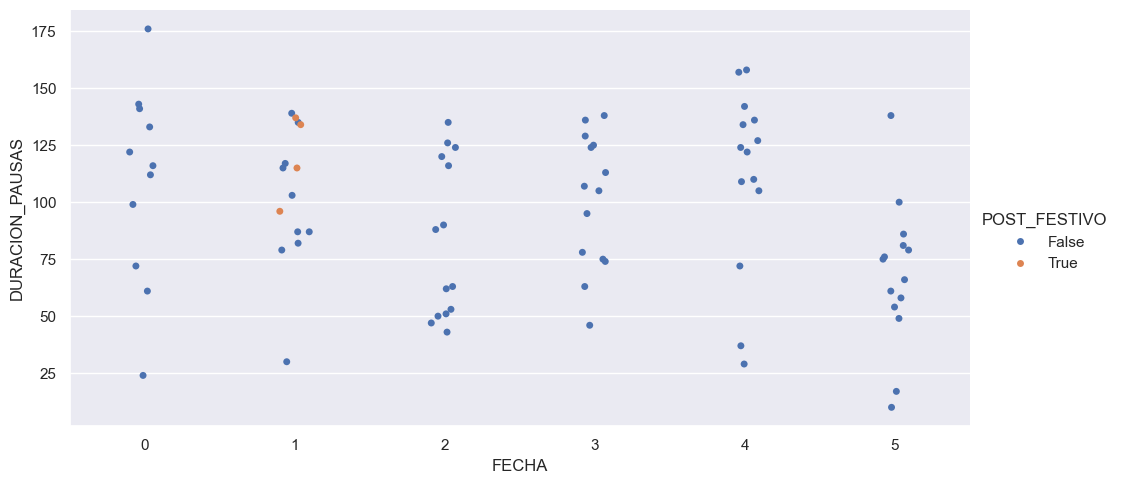

In [23]:
g=sns.catplot(x=df_sum["FECHA"].dt.day_of_week, y=df_sum["DURACION_PAUSAS"], hue=df_sum.POST_FESTIVO,  aspect=2)

### Conclusión
La duración total es la suma de la duración de las pausas y las tareas (no pausas). Existen valores extremos que se pueden atribuir a las pausas y otros valores relacionados con otra tareas
Las pausas tienen mucha variación en la duración, se ve un leve patron relacionado con el día de la semana pero no es se pudo comprobar con un modelo.

## Sin pausas

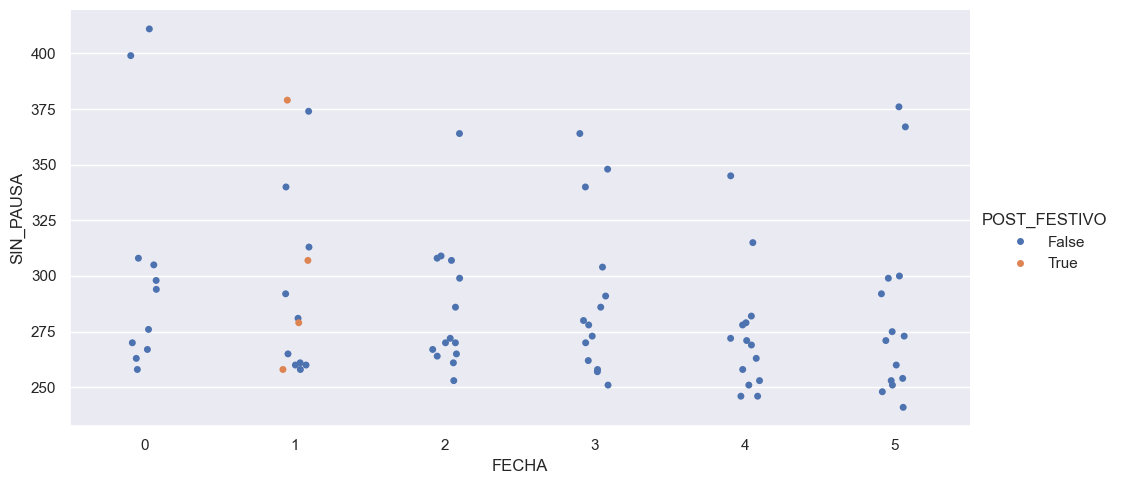

In [24]:
sns.set_theme(rc={'figure.figsize':(8,3)})
g=sns.catplot(x=df_sum["FECHA"].dt.day_of_week, y=df_sum["SIN_PAUSA"], hue=df_sum.POST_FESTIVO,  aspect=2)

### Conclusión
La variación en las tareas sin pausas también es alta. También se ve un leve patrón por los días de la semana pero los valores extremos superiores impiden caputurarlo en un modelo.
Los días festivos no parecen afectar la duración de las tareas sin pausas

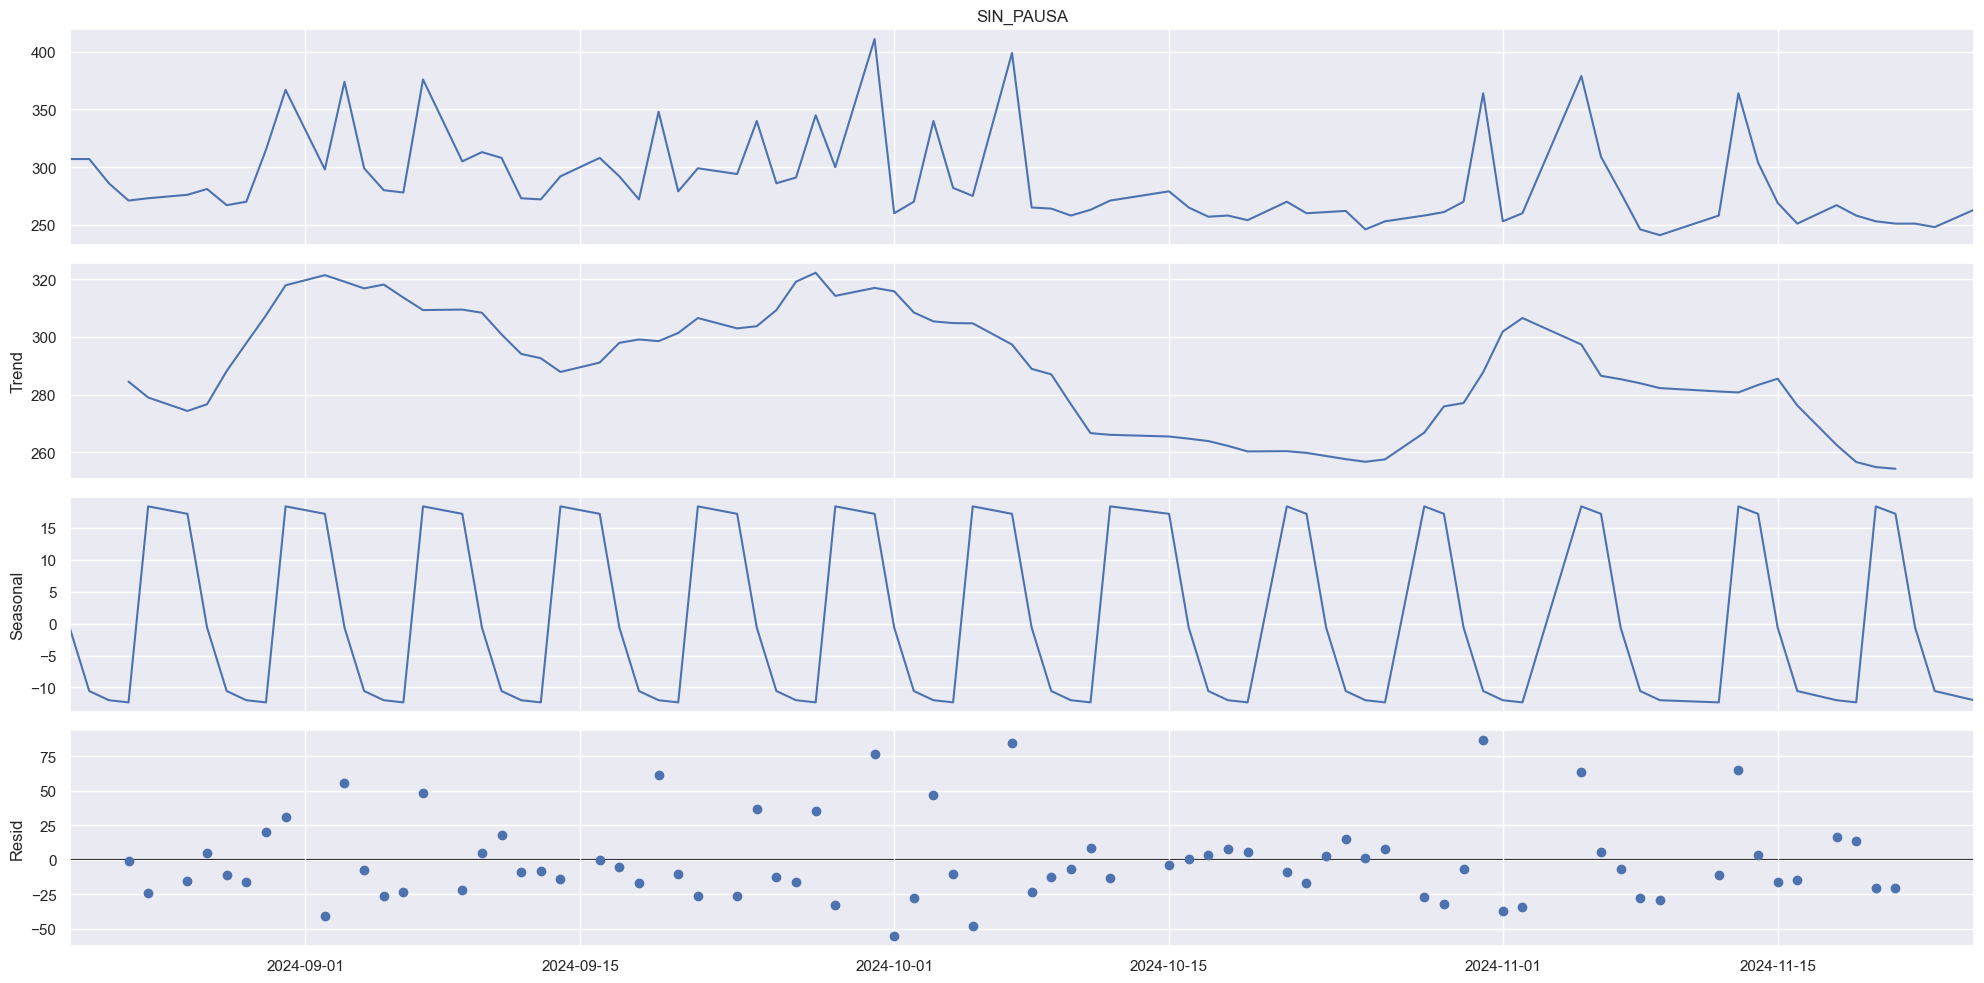

In [25]:
sns.set_theme(rc={'figure.figsize':(20,10)})
decompose_result_mult = seasonal_decompose(df_sum["SIN_PAUSA"], model="additive", period=6)

decompose_result_mult.plot();

## Tareas representativas

### Top tareas minutos totales

In [26]:
df_tareas_agg=df_parcial.groupby(["CODIGO_TAREA"], as_index=True,)["DURACION_MIN"].agg(["max","min","mean","median","count","sum"]	).sort_values("sum",ascending=False)


In [27]:
df_agg_top=df_tareas_agg.sort_values("sum",ascending=False).head(10)
df_agg_top

max   min       mean  median  count     sum
CODIGO_TAREA                                               
PAUSA         129.0   0.0  18.977941     4.0    408  7743.0
PBCGD017       42.0  27.0  34.111111    35.0     81  2763.0
PSNG9122       21.0  17.0  18.716049    19.0     81  1516.0
PJBWM077       22.0  14.0  17.641975    18.0     81  1429.0
PNU00217       32.0   8.0  17.049383    16.0     81  1381.0
PP017          30.0  12.0  16.753086    17.0     81  1357.0
PNU00002       22.0  10.0  15.407407    17.0     81  1248.0
PCC00003       26.0  11.0  14.246914    14.0     81  1154.0
PPP92005       45.0   9.0  13.777778    14.0     81  1116.0
PJBWP077       22.0   4.0   9.432099     9.0     81   764.0

In [28]:
lst_top=df_agg_top.index.to_list()
#sns.set_theme(rc={'figure.figsize':(20,2)})



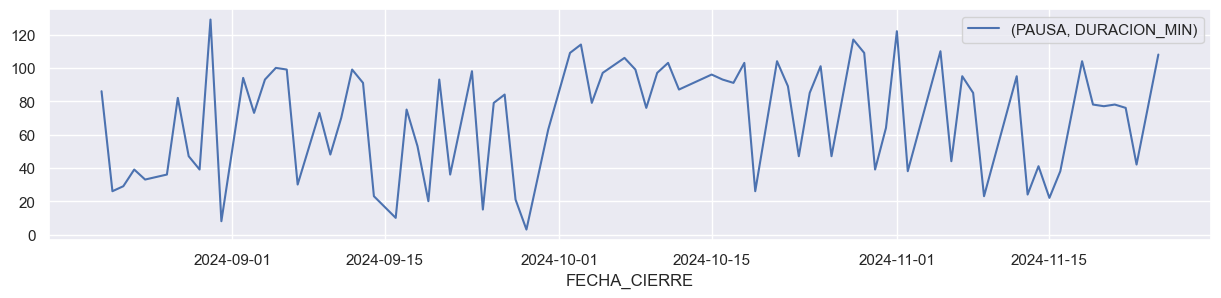

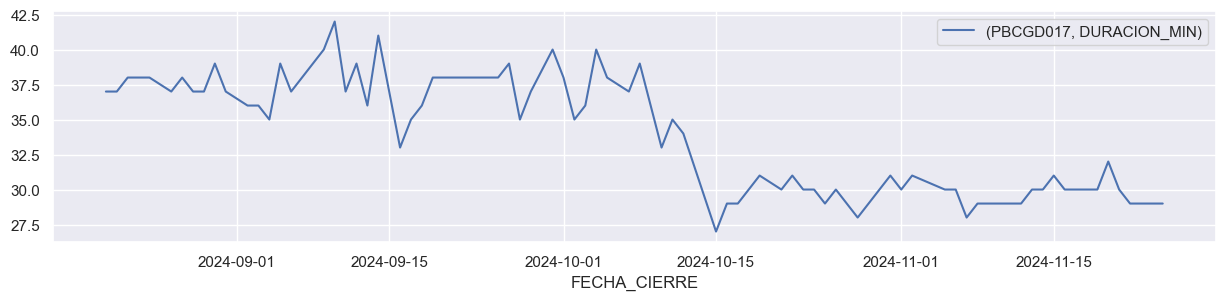

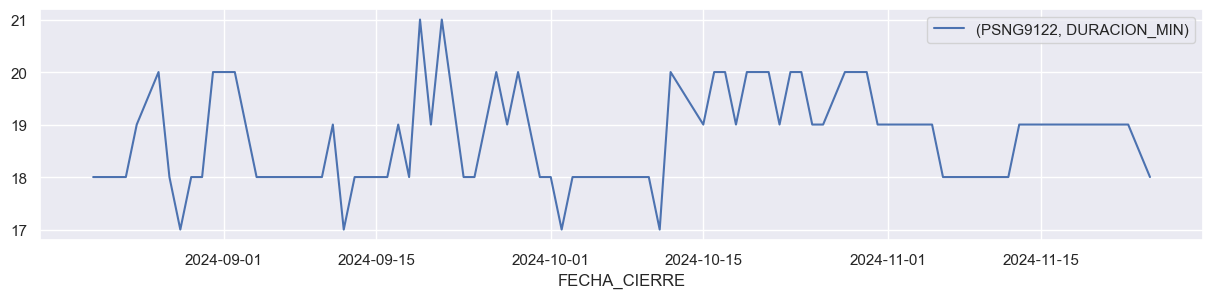

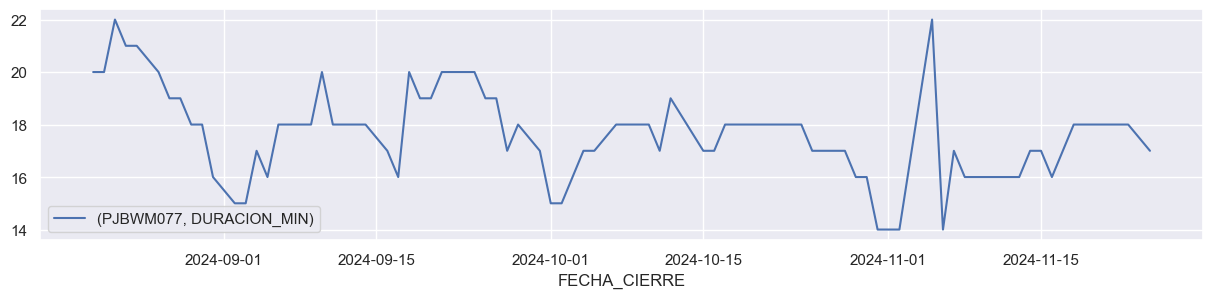

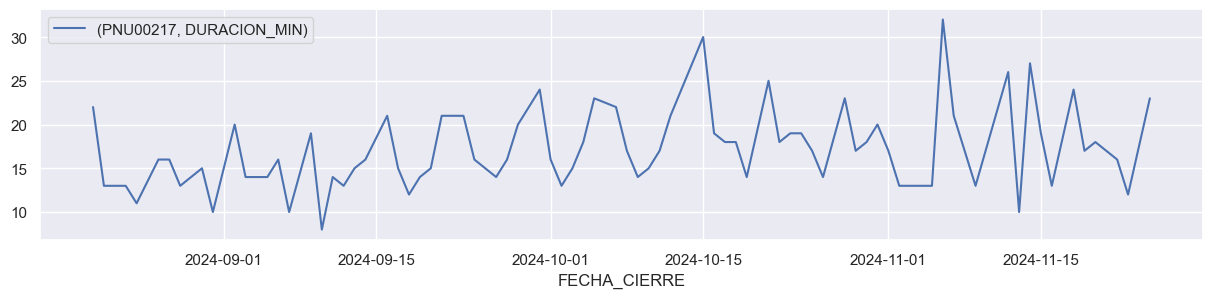

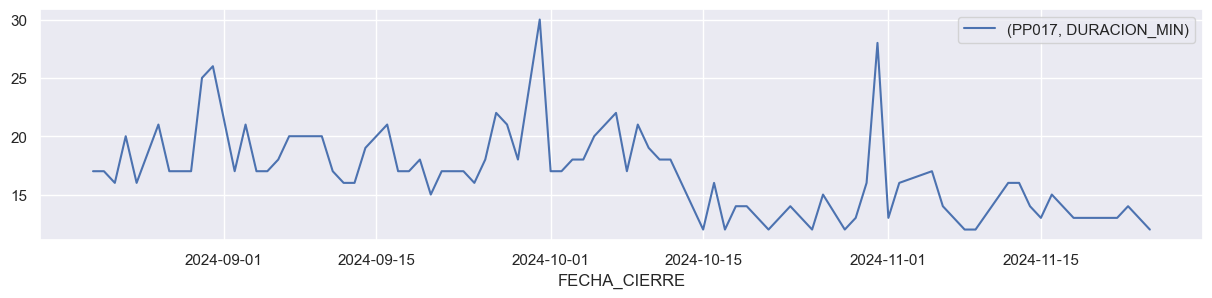

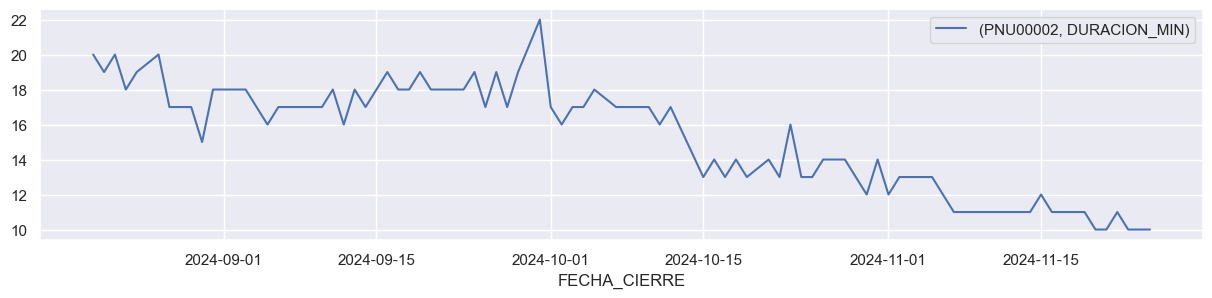

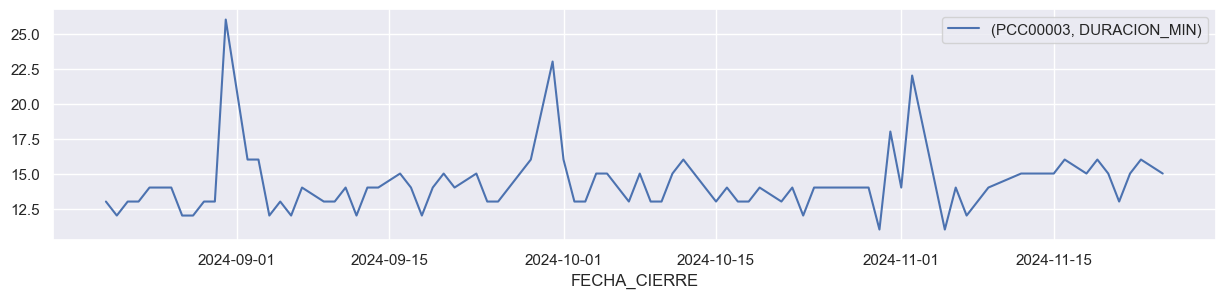

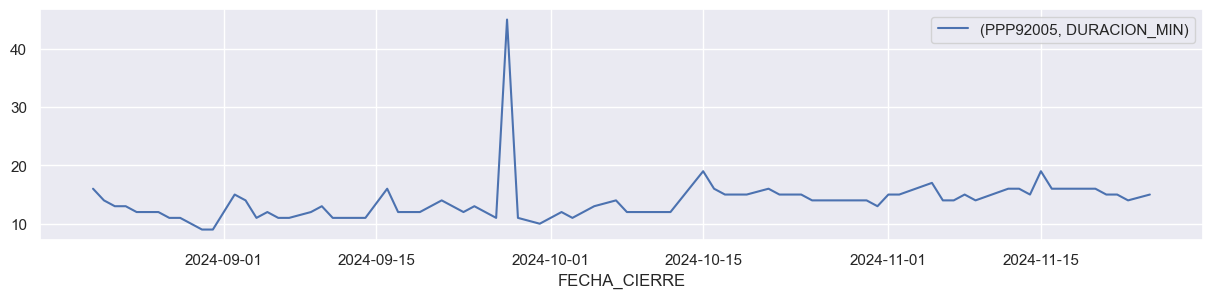

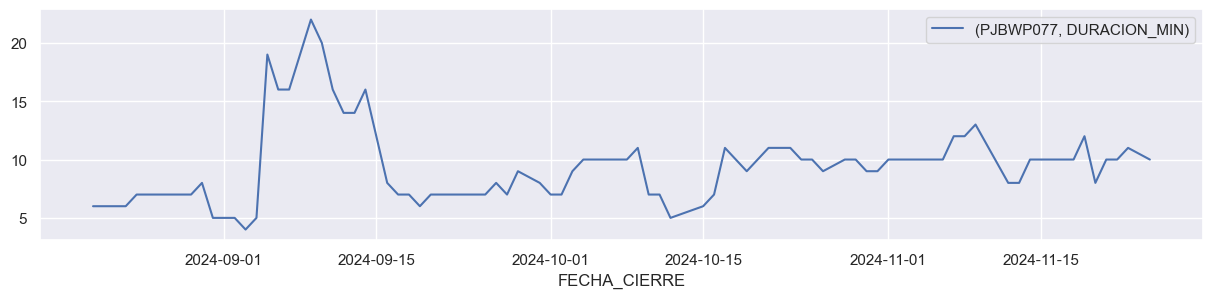

In [29]:
sns.set_theme(rc={'figure.figsize':(15,3)})
for tarea in df_tareas_agg.sort_values("sum",ascending=False).head(10).index:
     df_parcial[df_parcial["CODIGO_TAREA"]==tarea].groupby("FECHA_CIERRE")[["CODIGO_TAREA","DURACION_MIN"]].max().plot(by="CODIGO_TAREA")
    

### Ordenados por máximo

In [30]:
df_tareas_agg.sort_values("max",ascending=False).head(15)

max   min       mean  median  count     sum
CODIGO_TAREA                                               
PAUSA         129.0   0.0  18.977941     4.0    408  7743.0
PAHP900        66.0   0.0   0.814815     0.0     81    66.0
PP020FV2       59.0   1.0   5.777778     1.0     81   468.0
PNU00009       46.0   4.0   6.098765     5.0     81   494.0
PPP92005       45.0   9.0  13.777778    14.0     81  1116.0
PB098100       45.0   2.0  20.583333    18.0     36   741.0
PBCGD017       42.0  27.0  34.111111    35.0     81  2763.0
PP020A         37.0   3.0   7.432099     5.0     81   602.0
PNU00117       33.0   1.0   1.925926     1.0     81   156.0
PNU00217       32.0   8.0  17.049383    16.0     81  1381.0
PSNG917        31.0   6.0   7.654321     8.0     81   620.0
PP017          30.0  12.0  16.753086    17.0     81  1357.0
PBCGD011       28.0   1.0   2.901235     1.0     81   235.0
PCC00003       26.0  11.0  14.246914    14.0     81  1154.0
PJBWM077       22.0  14.0  17.641975    18.0     81  1429.0

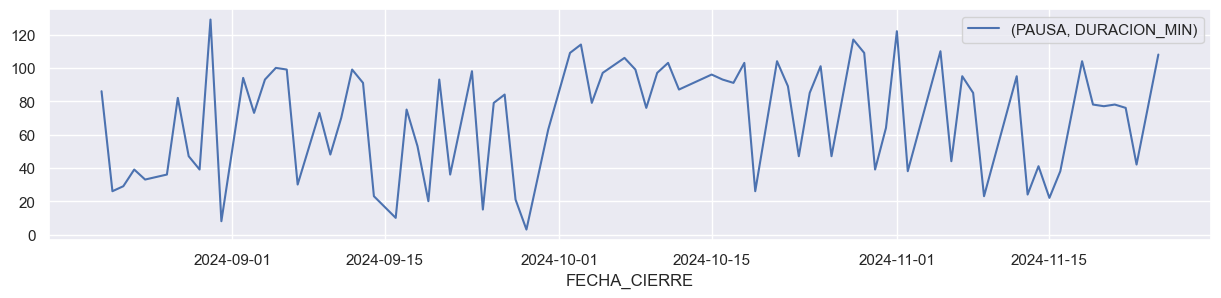

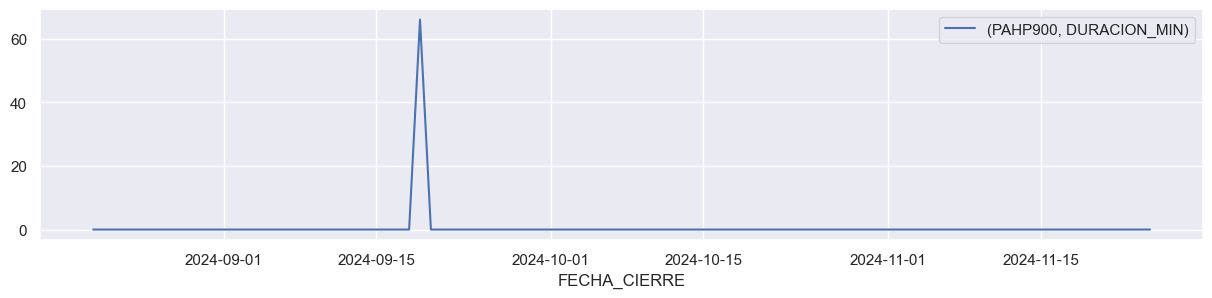

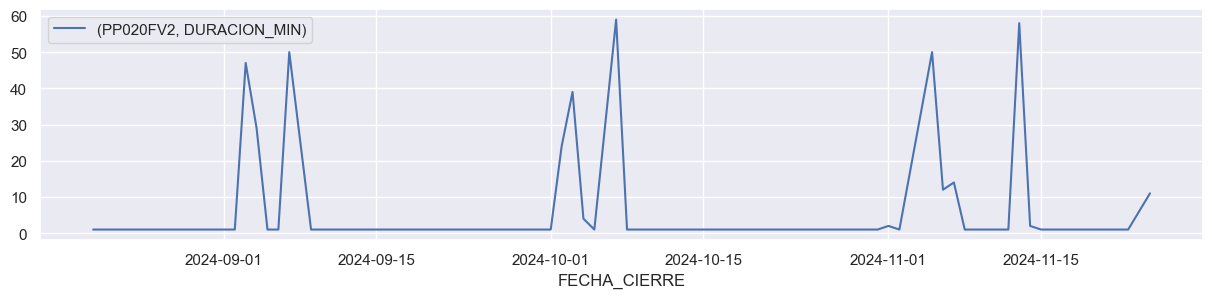

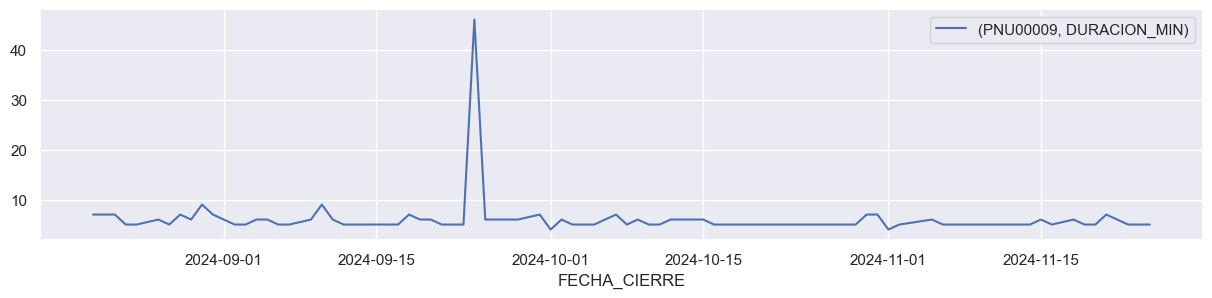

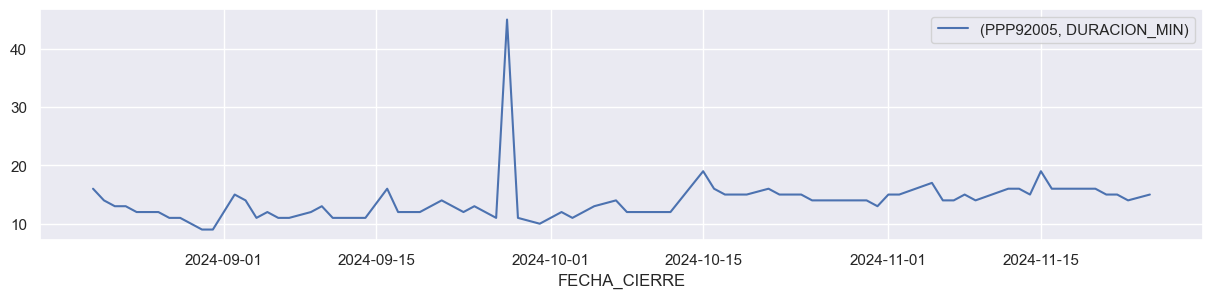

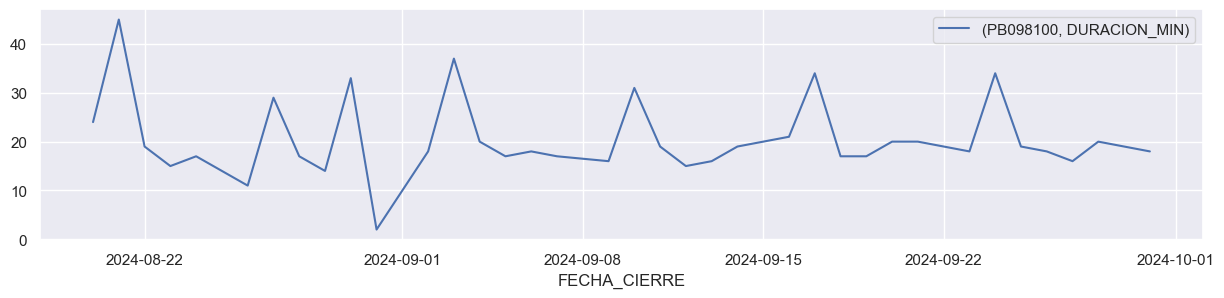

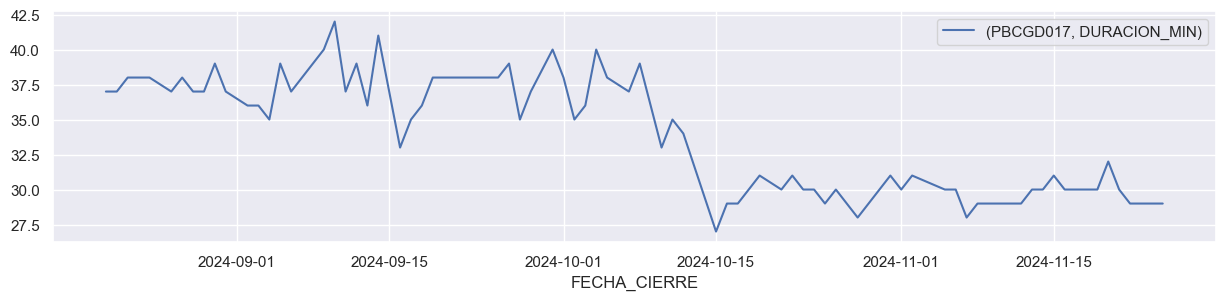

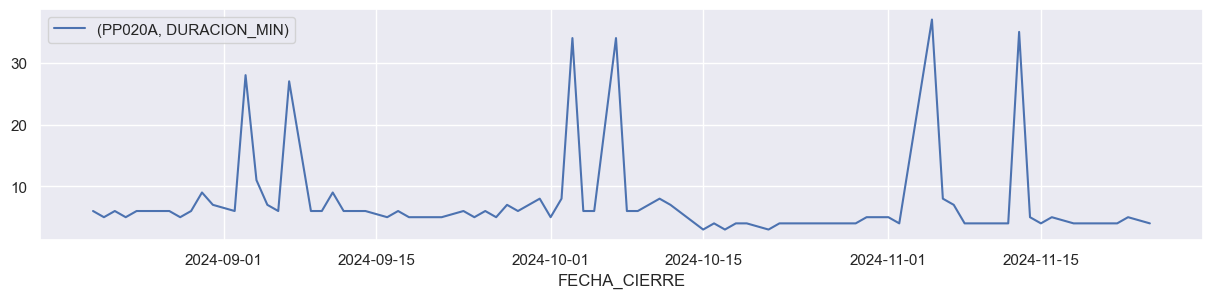

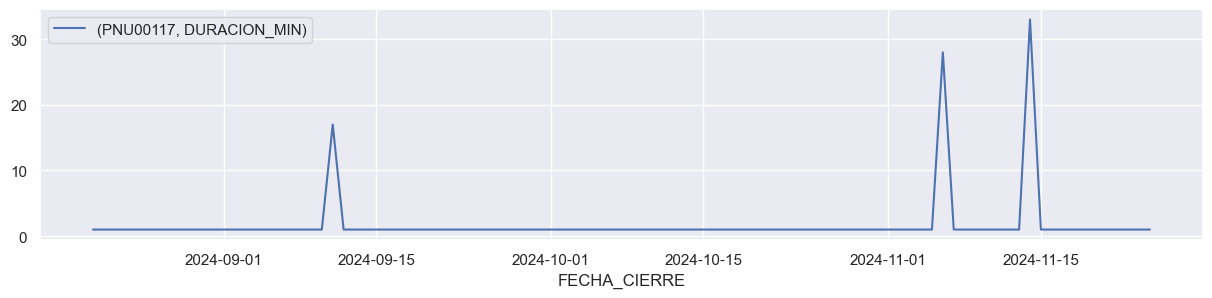

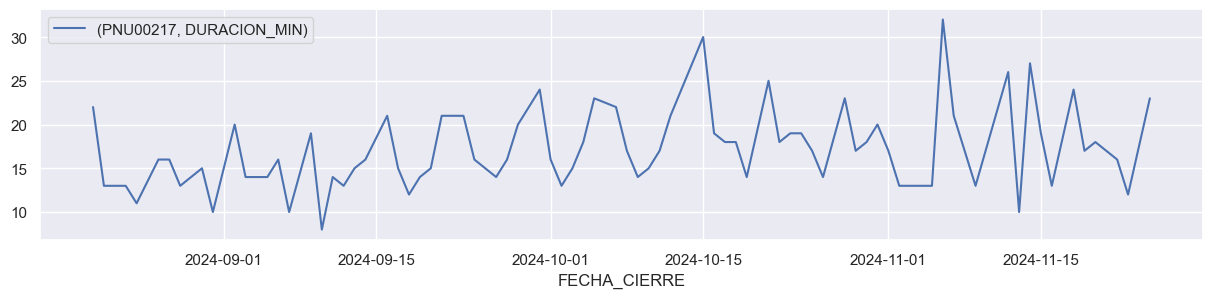

In [31]:

for tarea in df_tareas_agg.sort_values("max",ascending=False).head(10).index:
     df_parcial[df_parcial["CODIGO_TAREA"]==tarea].groupby("FECHA_CIERRE")[["CODIGO_TAREA","DURACION_MIN"]].max().plot(by="CODIGO_TAREA")
    

### Correlacion

In [32]:
df_tareas_agg.groupby("max").size()

max
0.0      67
1.0      23
2.0      14
3.0       3
4.0       6
5.0       4
6.0       4
7.0       1
8.0       1
9.0       3
10.0      3
11.0      1
12.0      1
13.0      1
15.0      1
21.0      1
22.0      3
26.0      1
28.0      1
30.0      1
31.0      1
32.0      1
33.0      1
37.0      1
42.0      1
45.0      2
46.0      1
59.0      1
66.0      1
129.0     1
dtype: int64

<Axes: xlabel='max'>

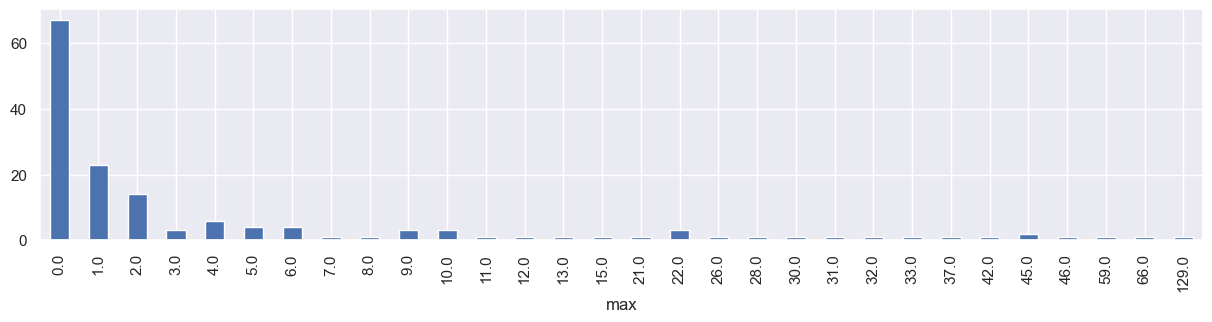

In [33]:
df_tareas_agg.groupby("max").size().plot.bar()


In [34]:
tareas_max5=df_tareas_agg[df_tareas_agg["max"]>5].index
tareas_max5
df_tareas_max5=df_parcial[df_parcial.CODIGO_TAREA.isin(tareas_max5)]

In [35]:
crosstab_df = pd.crosstab(df_tareas_max5['FECHA_CIERRE'], df_tareas_max5['CODIGO_TAREA'], values=df['DURACION_MIN'], aggfunc='sum').fillna(0)
crosstab_df.loc[:,"TOTAL"] = crosstab_df.sum(axis=1)
correlation_matrix = crosstab_df.corr()

<Axes: xlabel='CODIGO_TAREA', ylabel='CODIGO_TAREA'>

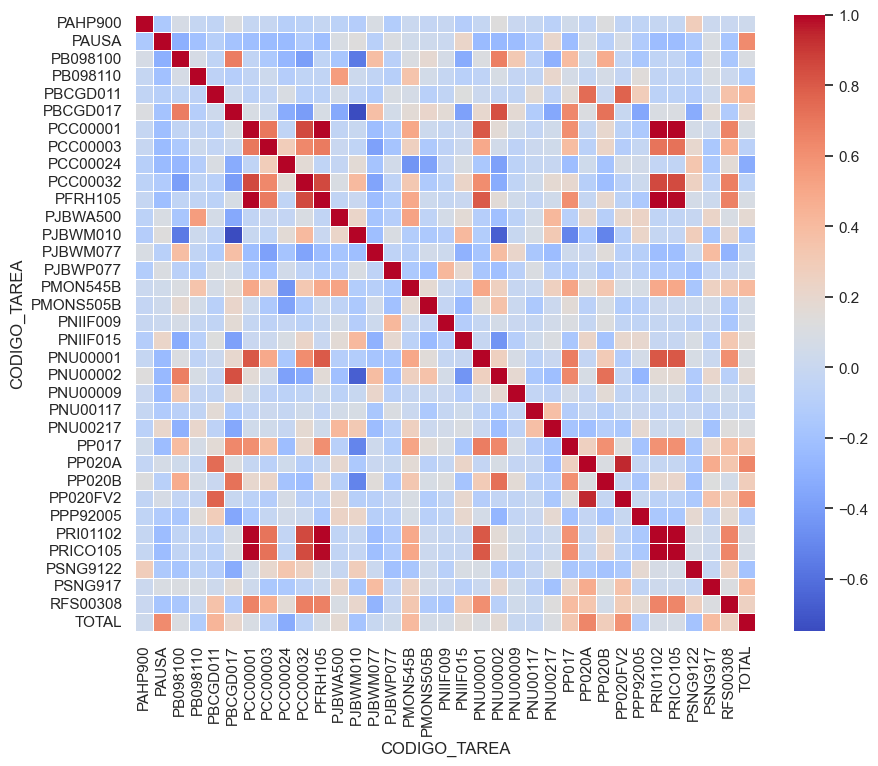

In [36]:

sns.set_theme(rc={'figure.figsize':(10,8)})

sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.2f', linewidths=0.5)

In [37]:
lst_seleccion=['PCC00001','PRICO105','PRI01102','PFRH105']
crosstab_df[lst_seleccion][crosstab_df.PCC00001>0]

CODIGO_TAREA  PCC00001  PRICO105  PRI01102  PFRH105
FECHA_CIERRE                                       
2024-08-31        11.0       9.0       6.0     12.0
2024-09-30        11.0       8.0       5.0     12.0
2024-10-31        11.0       7.0       5.0     13.0

<Axes: xlabel='FECHA_CIERRE'>

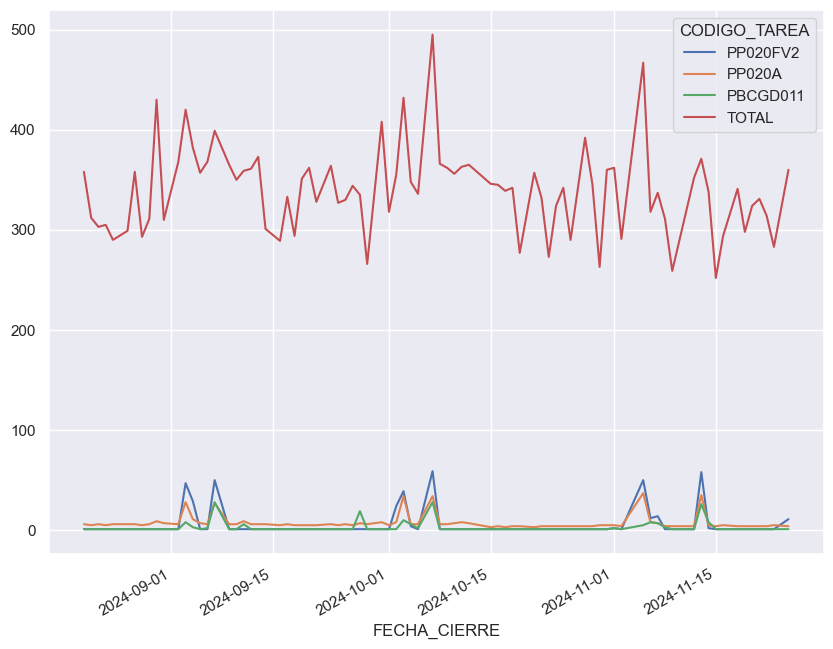

In [38]:
lst_seleccion=['PP020FV2','PP020A','PBCGD011',"TOTAL"]
crosstab_df[lst_seleccion].dropna(thresh=1).plot()
#for tarea in lst_seleccion:
#    df_parcial[df_parcial["CODIGO_TAREA"]==tarea].groupby("FECHA_CIERRE")[["CODIGO_TAREA","DURACION_MIN"]].max().plot(by="CODIGO_TAREA")


### Conclusión
Para el análisis de correlación se tomaron las tareas que han tenido tiempos máximos mayores a 5 minutos
se identificó que:
- las tareas 'PCC00001','PRICO105','PRI01102' estan relacionadas entre ellas porque se ejecutan al final de cada mes pero la duración es muy baja
- Las tareas tienen semejanza en los días de valores máximos 'PP020FV2','PP020A','PBCGD011' y parecen relacionados con la duraciones máximas de todo el proceso


### Agrupar tareas por comportamiento

In [39]:
df_crosstab_completo = pd.crosstab(df_parcial['CODIGO_TAREA'], df_parcial['FECHA_CIERRE'], values=df['DURACION_MIN'], aggfunc='sum').reset_index()
df_crosstab_completo.fillna(0,inplace=True) 
scaler = StandardScaler()
duraciones_normalizadas = scaler.fit_transform(df_crosstab_completo.iloc[:, 1:])


In [40]:
dbscan = DBSCAN(eps=.2, min_samples=3) 
clusters=dbscan.fit_predict(duraciones_normalizadas)
df_crosstab_completo["GRUPO"]=clusters

In [41]:
df_crosstab_completo.groupby("GRUPO").size() [df_crosstab_completo.groupby("GRUPO").size() > 1]

GRUPO
-1    60
 0    70
 1     6
 2    12
 3     3
dtype: int64

In [42]:
sns.set_theme(rc={'figure.figsize':(20,3)})
df_crosstab_completo.set_index('CODIGO_TAREA', inplace=True)


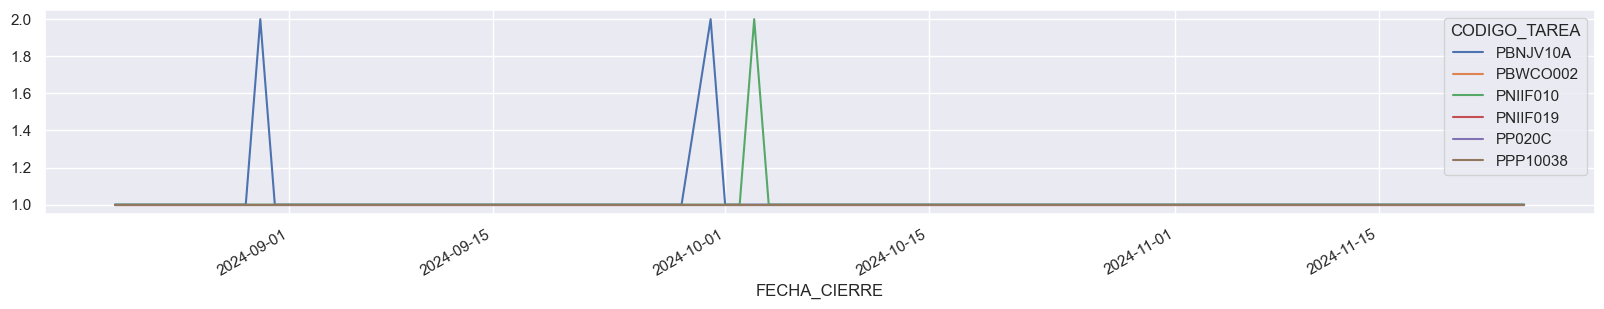

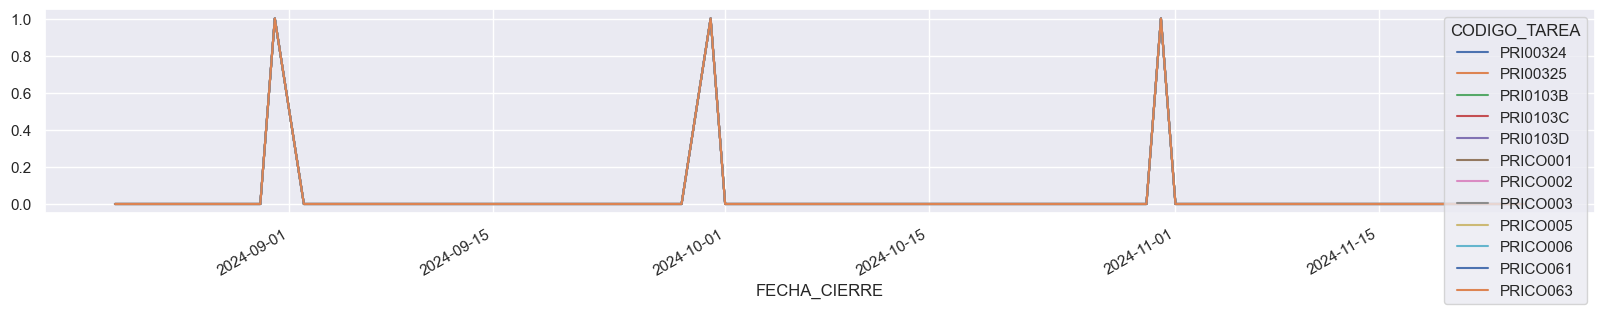

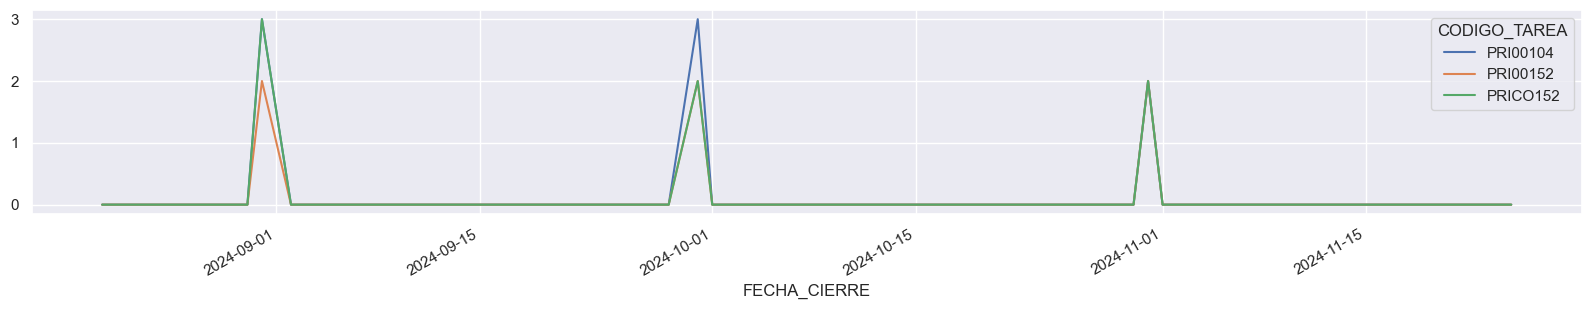

In [43]:
for grupo in [1,2,3]:
   (df_crosstab_completo[df_crosstab_completo.GRUPO==grupo]).transpose().drop(index=["GRUPO"]).plot()


In [44]:
# Seleccionar un número de clusters y aplicar K-means
kmeans = KMeans(n_clusters=7, random_state=42)  # Cambiar el número según el método del codo
clusters = kmeans.fit_predict(duraciones_normalizadas)
df_crosstab_completo["GRUPO"]=clusters
df_crosstab_completo.groupby("GRUPO").size()
#df_crosstab_completo.set_index('CODIGO_TAREA',inplace=True)


GRUPO
0     12
1    129
2      1
3      1
4      6
5      1
6      1
dtype: int64

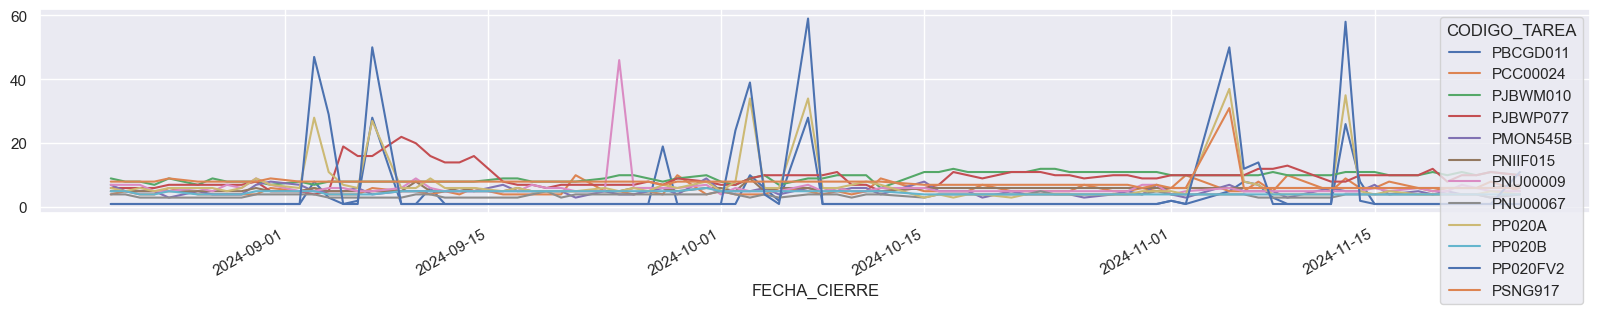

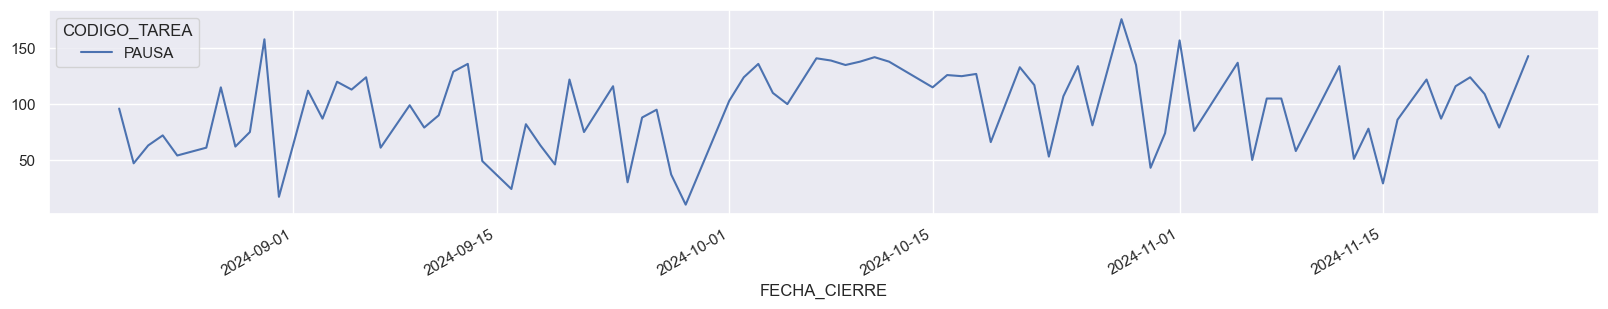

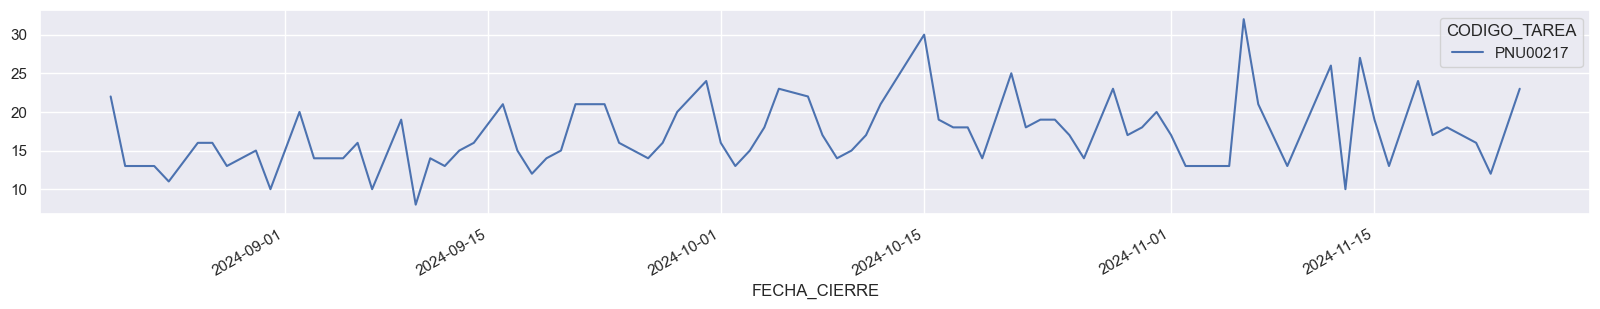

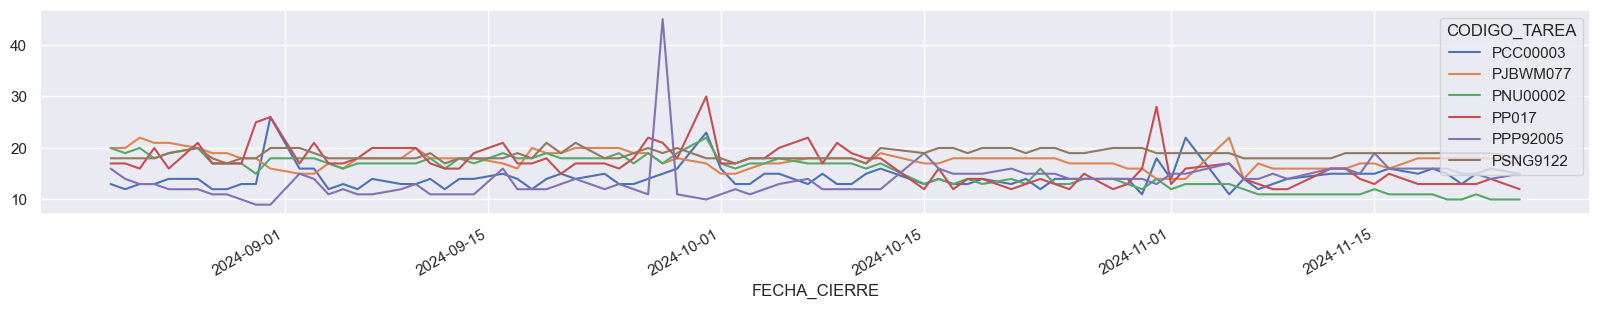

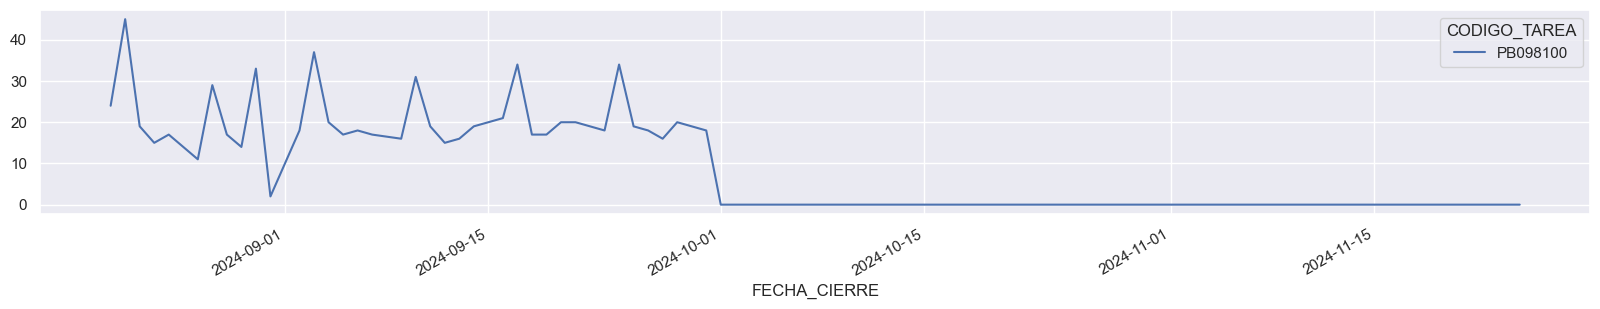

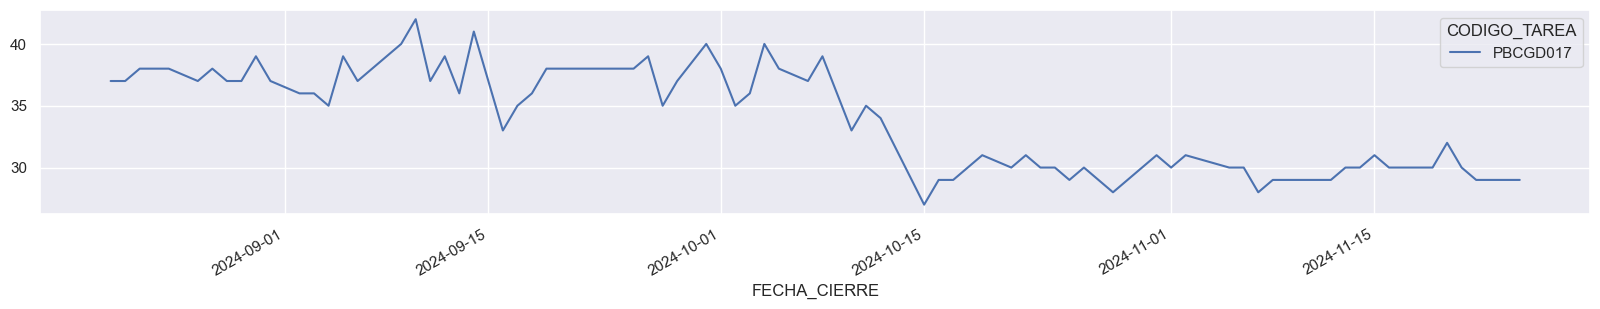

In [45]:
sns.set_theme(rc={'figure.figsize':(20,3)})
for grupo in range(7):
    if grupo  not in (1,):
        (df_crosstab_completo[df_crosstab_completo.GRUPO==grupo]).transpose().drop(index=["GRUPO"]).plot()


### Conclusión
Con los modelos de agrupamiento no se logró identificar grupos de tareas que se tengan aumentos o disminuciones de duración el mismo día (correlacionadas).
Las principales agrupaciones fueron entre proceso cuya duración son inferiores al minuto.
Se crean grupo individuales para las tareas que tienen máximos algunos días del mes, como:
```
PAHP900 	66 mins 1 vez en 3 meses
PP020FV2	60 mins 2 veces al mes
PP020A		60 mins 2 veces al mes
PBCGD011	60 mins 2 veces al mes
PPP92005	45.0	1 vez en los 3 meses
PB098100	40 o más 1 vez cada semana
PPP92005	45.0 una vez al mes

PNU00117    30 mins 2 veces al mes
PNU00217    30 mins 2 veces al mes
PP020A		60 mins 2 veces al mes
PBCGD011	60 mins 2 veces al mes

PBCGD017    por debajo de 40 mins hace un mes
```

In [46]:
lst_representativas = [
    'PAHP900',
'PP020FV2',
'PP020A',
'PBCGD011',
'PPP92005',
'PB098100',
'PPP92005',
'PNU00117',
'PNU00217',
'PP020A',
]


In [47]:

lst_representativas = [
'PP020FV2',
'PP020A',
'PNU00117',
'PNU00217',
#'PB098100'
]


In [48]:

df_rep=df_parcial[df_parcial.CODIGO_TAREA.isin(lst_representativas)].groupby("FECHA_CIERRE", as_index=False)["DURACION_MIN"].sum()
df_rep.set_index("FECHA_CIERRE", inplace=True)
df_rep.rename(columns={"DURACION_MIN":"REPRESENTATIVAS"},inplace=True)
df_sum2=df_sum.join(df_rep)


In [49]:
df_parcial[df_parcial.CODIGO_TAREA.isin(lst_representativas)][["CODIGO_TAREA","DESCRIPCION_TAREA"]].value_counts()

CODIGO_TAREA  DESCRIPCION_TAREA             
PNU00117      Pasaje Resultados FVC             81
PNU00217      Pasaje Resultados M/E a M/N Ac    81
PP020A        Pasaje a Historico FSH015-16 *    81
PP020FV2      PASAJE A HISTORICOS DE MOVIMI     81
Name: count, dtype: int64

<Axes: xlabel='FECHA_CIERRE'>

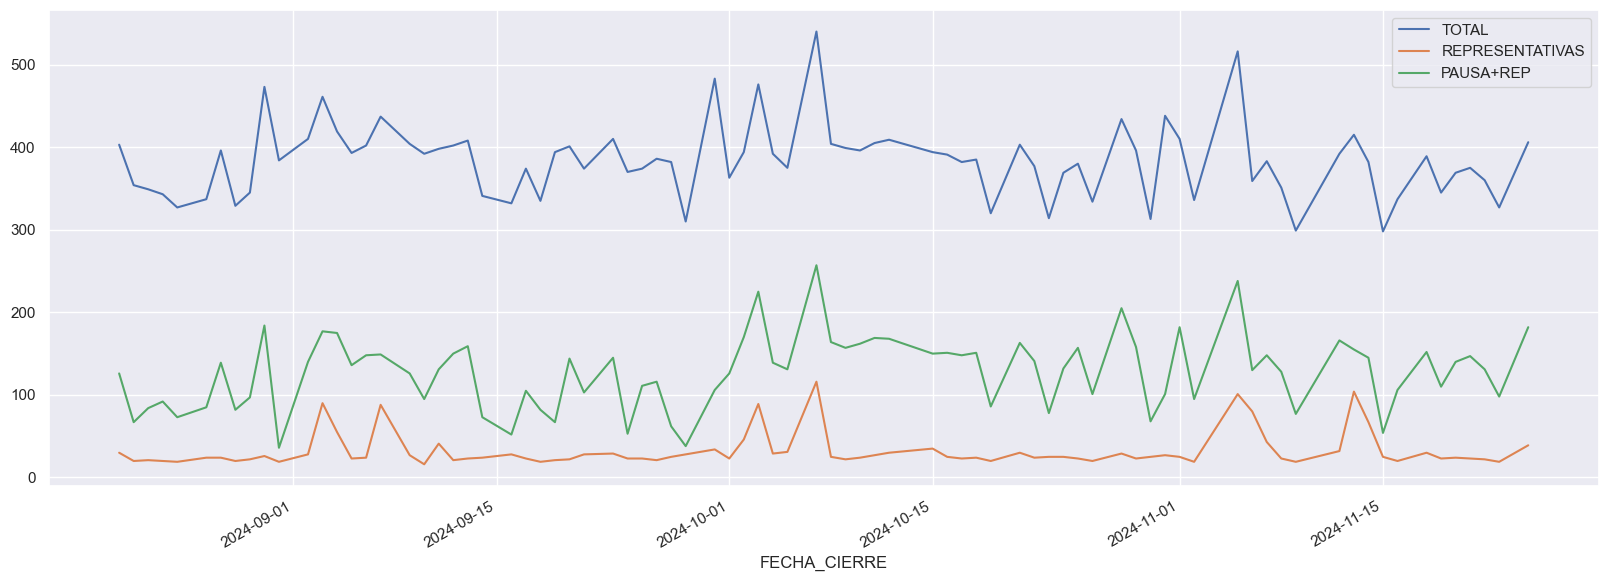

In [50]:
df_sum2["PAUSA+REP"]=df_sum2.DURACION_PAUSAS + df_sum2.REPRESENTATIVAS
df_sum2["PORCENTAJE"]=df_sum2["PAUSA+REP"]/df_sum2["TOTAL"]*100
df_sum2["DIF"]=df_sum2["TOTAL"]-df_sum2["PAUSA+REP"]

sns.set_theme(rc={'figure.figsize':(20,7)})
df_sum2[["TOTAL","REPRESENTATIVAS","PAUSA+REP",]].plot()


<Axes: xlabel='FECHA_CIERRE'>

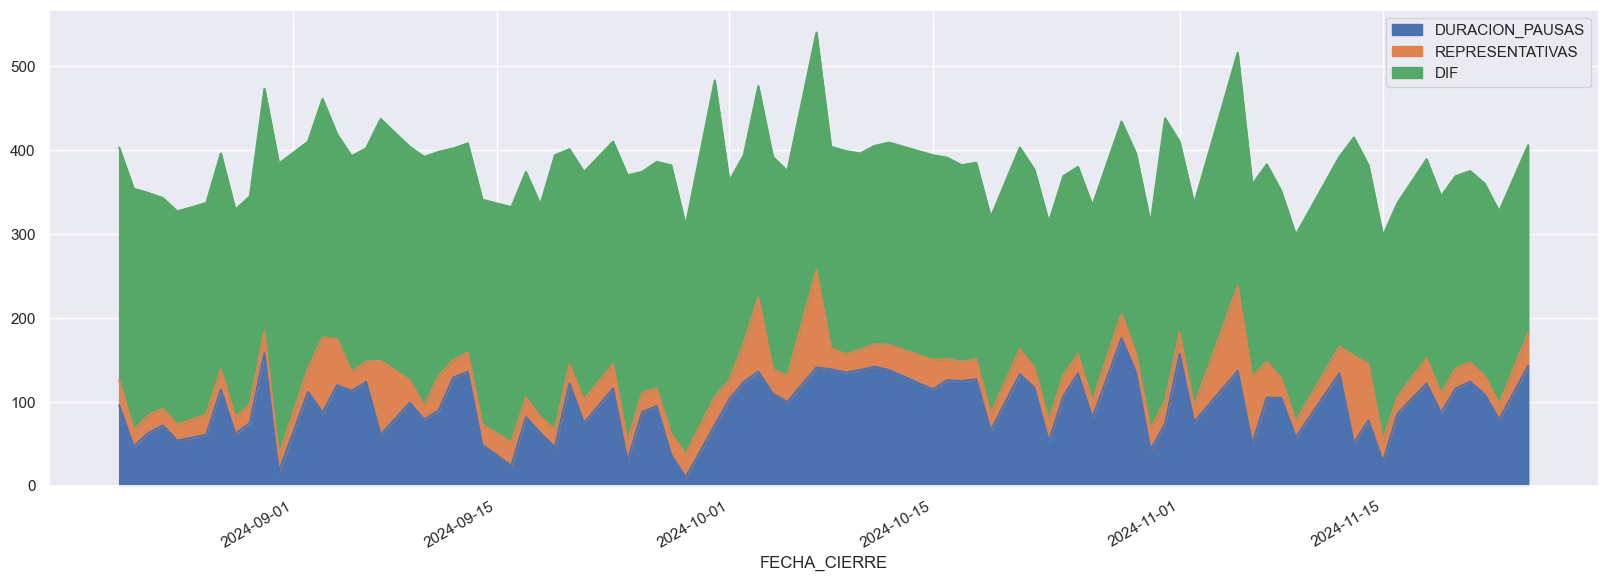

In [51]:
df_sum2[["DURACION_PAUSAS","REPRESENTATIVAS","DIF",]].plot.area()

In [52]:
df_sum2[["TOTAL","DURACION_PAUSAS","REPRESENTATIVAS","PAUSA+REP","PORCENTAJE","DIF"]]

TOTAL  DURACION_PAUSAS  REPRESENTATIVAS  PAUSA+REP  PORCENTAJE  \
FECHA_CIERRE                                                                   
2024-08-20    403.0             96.0             30.0      126.0   31.265509   
2024-08-21    354.0             47.0             20.0       67.0   18.926554   
2024-08-22    349.0             63.0             21.0       84.0   24.068768   
2024-08-23    343.0             72.0             20.0       92.0   26.822157   
2024-08-24    327.0             54.0             19.0       73.0   22.324159   
...             ...              ...              ...        ...         ...   
2024-11-20    369.0            116.0             24.0      140.0   37.940379   
2024-11-21    375.0            124.0             23.0      147.0   39.200000   
2024-11-22    360.0            109.0             22.0      131.0   36.388889   
2024-11-23    327.0             79.0             19.0       98.0   29.969419   
2024-11-25    406.0            143.0             39.0      182.0   44.827586   

                DIF  
FECHA_CIERRE         
2024-08-20    277.0  
2024-08-21    287.0  
2024-08-22    265.0  
2024-08-23    251.0  
2024-08-24    254.0  
...             ...  
2024-11-20    229.0  
2024-11-21    228.0  
2024-11-22    229.0  
2024-11-23    229.0  
2024-11-25    224.0  

[81 rows x 6 columns]

<Axes: xlabel='FECHA_CIERRE'>

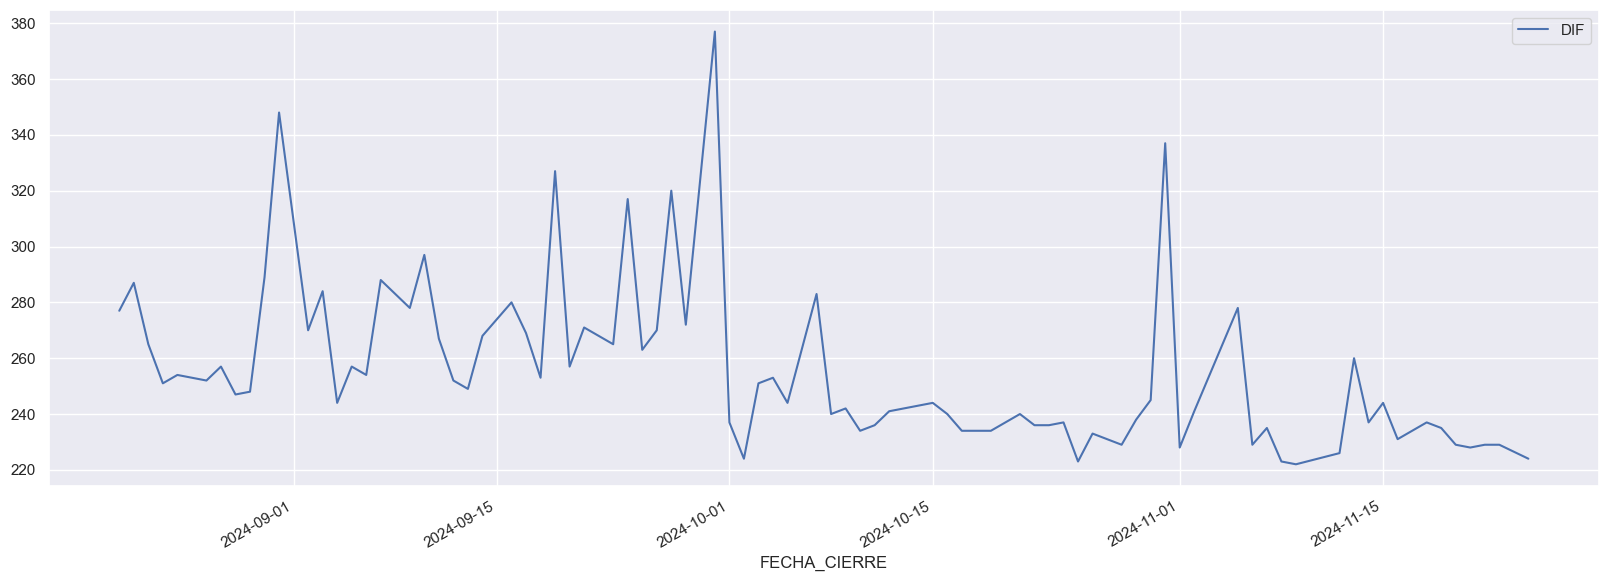

In [53]:
df_sum2[["DIF"]].plot()

### Modelo predictivo

In [54]:
df_sum

TAREA_MAX  TOTAL  DURACION_PAUSAS  SIN_PAUSA      FECHA  \
FECHA_CIERRE                                                            
2024-08-20         86.0  403.0             96.0      307.0 2024-08-20   
2024-08-21         45.0  354.0             47.0      307.0 2024-08-21   
2024-08-22         38.0  349.0             63.0      286.0 2024-08-22   
2024-08-23         39.0  343.0             72.0      271.0 2024-08-23   
2024-08-24         38.0  327.0             54.0      273.0 2024-08-24   
...                 ...    ...              ...        ...        ...   
2024-11-20         77.0  369.0            116.0      253.0 2024-11-20   
2024-11-21         78.0  375.0            124.0      251.0 2024-11-21   
2024-11-22         76.0  360.0            109.0      251.0 2024-11-22   
2024-11-23         42.0  327.0             79.0      248.0 2024-11-23   
2024-11-25        108.0  406.0            143.0      263.0 2024-11-25   

              POST_FESTIVO  
FECHA_CIERRE                
2024-08-20            True  
2024-08-21           False  
2024-08-22           False  
2024-08-23           False  
2024-08-24           False  
...                    ...  
2024-11-20           False  
2024-11-21           False  
2024-11-22           False  
2024-11-23           False  
2024-11-25           False  

[81 rows x 6 columns]

In [55]:
df_regressor = pd.crosstab( df_parcial['FECHA_CIERRE'], df_parcial['CODIGO_TAREA'], values=df['DURACION_SEGUNDOS'], aggfunc='sum').reset_index()
df_regressor.fillna(0,inplace=True) 
df_regressor.loc[:,"TOTAL"]=df_regressor[df_regressor.columns[1:]].sum(axis=1,)


In [56]:
df_regressor


CODIGO_TAREA FECHA_CIERRE  OCIE1000  PAHP900  PAR00280   PAUSA  PB098100  \
0              2024-08-20       2.0     11.0      17.0  5758.0    1460.0   
1              2024-08-21       1.0     10.0      17.0  2805.0    2675.0   
2              2024-08-22       2.0     10.0      17.0  3779.0    1146.0   
3              2024-08-23       1.0     11.0      19.0  4314.0     879.0   
4              2024-08-24       2.0     10.0      18.0  3254.0    1011.0   
..                    ...       ...      ...       ...     ...       ...   
76             2024-11-20       1.0     10.0      18.0  6923.0       0.0   
77             2024-11-21       1.0     10.0      17.0  7468.0       0.0   
78             2024-11-22       1.0     10.0      17.0  6534.0       0.0   
79             2024-11-23       1.0     10.0      17.0  4777.0       0.0   
80             2024-11-25       1.0     10.0      17.0  8536.0       0.0   

CODIGO_TAREA  PB098105  PB098110  PB098540  PB098541  ...  PSID0003  PSNG9122  \
0                 20.0      97.0       2.0       3.0  ...       1.0    1073.0   
1                 18.0      56.0       3.0       3.0  ...       1.0    1081.0   
2                 19.0      42.0       2.0       3.0  ...       1.0    1108.0   
3                 19.0      49.0       3.0       2.0  ...       1.0    1075.0   
4                 20.0      37.0       2.0       2.0  ...       1.0    1127.0   
..                 ...       ...       ...       ...  ...       ...       ...   
76                18.0      77.0       2.0       2.0  ...       1.0    1129.0   
77                18.0      52.0       1.0       2.0  ...       1.0    1127.0   
78                19.0      47.0       2.0       2.0  ...       1.0    1154.0   
79                19.0      40.0       2.0       3.0  ...       1.0    1118.0   
80                18.0      47.0       3.0       2.0  ...       1.0    1097.0   

CODIGO_TAREA  PSNG917  PSNG917A  PX17066I  PX999C17  PX999W17  RFS00099  \
0               487.0       2.0       1.0       1.0       1.0      41.0   
1               504.0       2.0       1.0       1.0       2.0      38.0   
2               489.0       1.0       1.0       1.0       1.0      32.0   
3               500.0       1.0       2.0       1.0       1.0      26.0   
4               531.0       2.0       1.0       2.0       1.0      15.0   
..                ...       ...       ...       ...       ...       ...   
76              387.0       1.0       1.0       1.0       1.0      29.0   
77              386.0       1.0       2.0       1.0       1.0      24.0   
78              388.0       1.0       1.0       1.0       1.0      25.0   
79              384.0       2.0       2.0       1.0       1.0     116.0   
80              372.0       1.0       1.0       1.0       1.0      33.0   

CODIGO_TAREA  RFS00308    TOTAL  
0                163.0  24250.0  
1                153.0  21490.0  
2                147.0  21147.0  
3                144.0  20905.0  
4                161.0  19864.0  
..                 ...      ...  
76               166.0  22684.0  
77               155.0  22788.0  
78               153.0  21917.0  
79               189.0  19942.0  
80               179.0  24664.0  

[81 rows x 153 columns]

In [57]:
from sklearn.ensemble import GradientBoostingRegressor

y_train= df_regressor["TOTAL"]
X_train= df_regressor[df_regressor.columns[1:-1]]
# Entrenamiento
model_xgb = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
model_xgb.fit(X_train, y_train)

# Importancia de características
importancias = model_xgb.feature_importances_

        Tarea  Importancia
105    PP020A     0.364640
3       PAUSA     0.261146
88   PNIIF019     0.098397
149  RFS00099     0.020725
150  RFS00308     0.017956
78   PNIIF008     0.015936
96   PNU00067     0.015481
68   PMON515D     0.012715
32   PCI00010     0.012167
104     PP017     0.011468


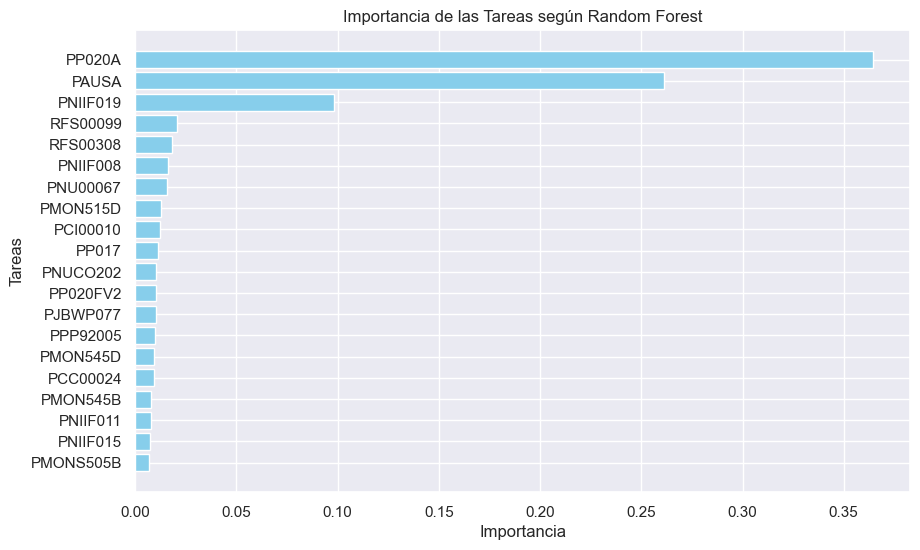

In [58]:
importancia_tareas = pd.DataFrame({
    'Tarea': X_train.columns,
    'Importancia': importancias
}).sort_values(by='Importancia', ascending=False)

# Mostrar las tareas más importantes
print(importancia_tareas.head(10))

# Graficar la importancia
plt.figure(figsize=(10, 6))
plt.barh(importancia_tareas.head(20)['Tarea'], importancia_tareas.head(20)['Importancia'], color='skyblue')
plt.xlabel('Importancia')
plt.ylabel('Tareas')
plt.title('Importancia de las Tareas según Random Forest')
plt.gca().invert_yaxis()  # Invertir el eje Y para que las más importantes estén arriba
plt.show()

In [59]:

lst_representativas2 = [
'PP020FV2',
'PP020A',
'RFS00308',
'PP017',
'PNU00009',
 'PNIIF015',
 'PNU00001'
]


In [60]:

df_rep2=df_parcial[df_parcial.CODIGO_TAREA.isin(lst_representativas2)].groupby("FECHA_CIERRE", as_index=False)["DURACION_MIN"].sum()
df_rep2.set_index("FECHA_CIERRE", inplace=True)
df_rep2.rename(columns={"DURACION_MIN":"REPRESENTATIVAS"},inplace=True)
df_sum3=df_sum.join(df_rep2)


In [61]:
df_parcial[df_parcial.CODIGO_TAREA.isin(lst_representativas2)][["CODIGO_TAREA","DESCRIPCION_TAREA"]].value_counts()

CODIGO_TAREA  DESCRIPCION_TAREA             
PNU00001      Pasaje de rubros                  84
PNIIF015      Copia Clientes y Sucursales de    81
PNU00009      Ajuste de Operaciones Cancelad    81
PP017         Depurador                         81
PP020A        Pasaje a Historico FSH015-16 *    81
PP020FV2      PASAJE A HISTORICOS DE MOVIMI     81
RFS00308      Lista Asientos F.Valor Contabl    81
Name: count, dtype: int64

<Axes: xlabel='FECHA_CIERRE'>

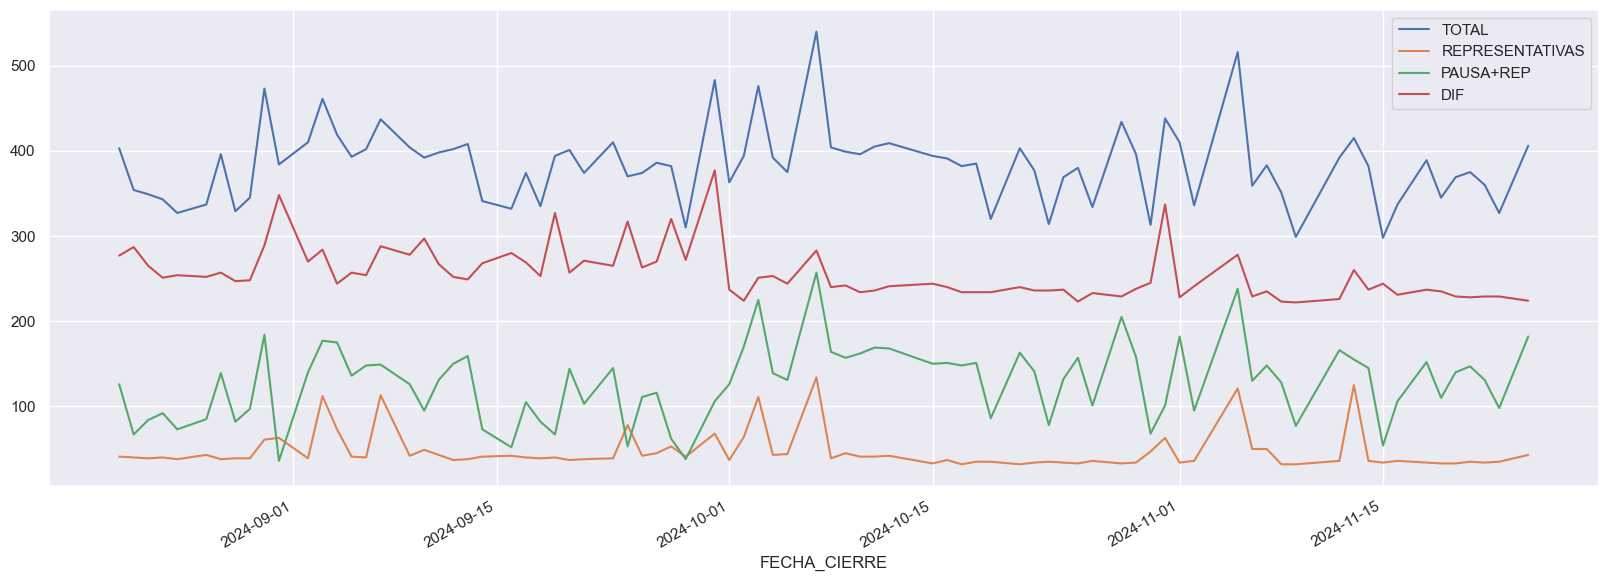

In [62]:
df_sum3["PAUSA+REP"]=df_sum3.DURACION_PAUSAS + df_sum2.REPRESENTATIVAS
df_sum3["PORCENTAJE"]=df_sum3["PAUSA+REP"]/df_sum3["TOTAL"]*100
df_sum3["DIF"]=df_sum3["TOTAL"]-df_sum3["PAUSA+REP"]

sns.set_theme(rc={'figure.figsize':(20,7)})
df_sum3[["TOTAL","REPRESENTATIVAS","PAUSA+REP","DIF"]].plot()


<Axes: xlabel='FECHA_CIERRE'>

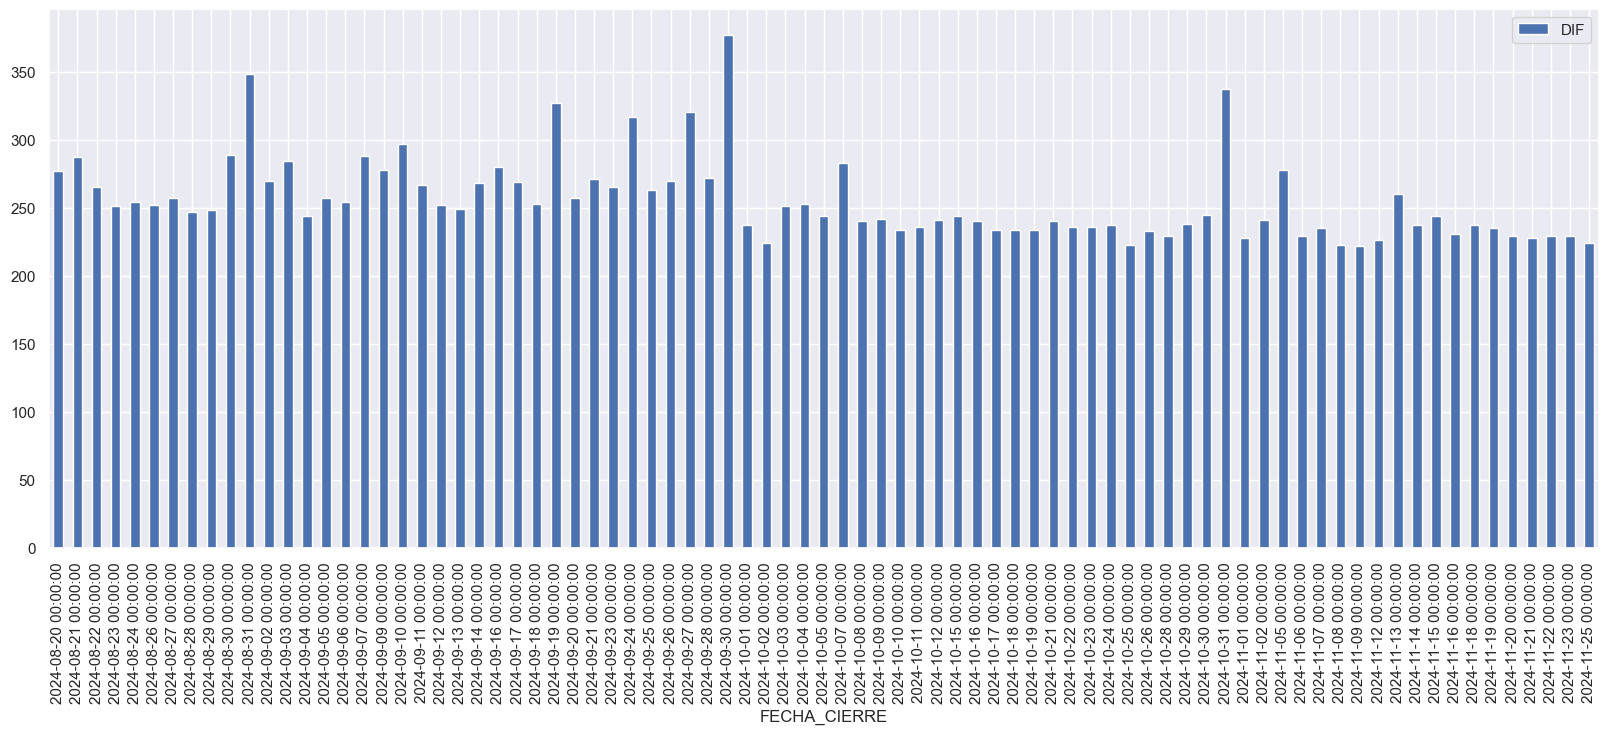

In [63]:
df_sum3[["DIF"]].plot.bar()

In [64]:
lst_oct31=df_parcial[["CODIGO_TAREA","DESCRIPCION_TAREA","DURACION_SEGUNDOS"]][df_parcial.FECHA_CIERRE==pd.to_datetime(date(2024,10,31))].sort_values("DURACION_SEGUNDOS",ascending=False).head(10)['CODIGO_TAREA'].to_list()

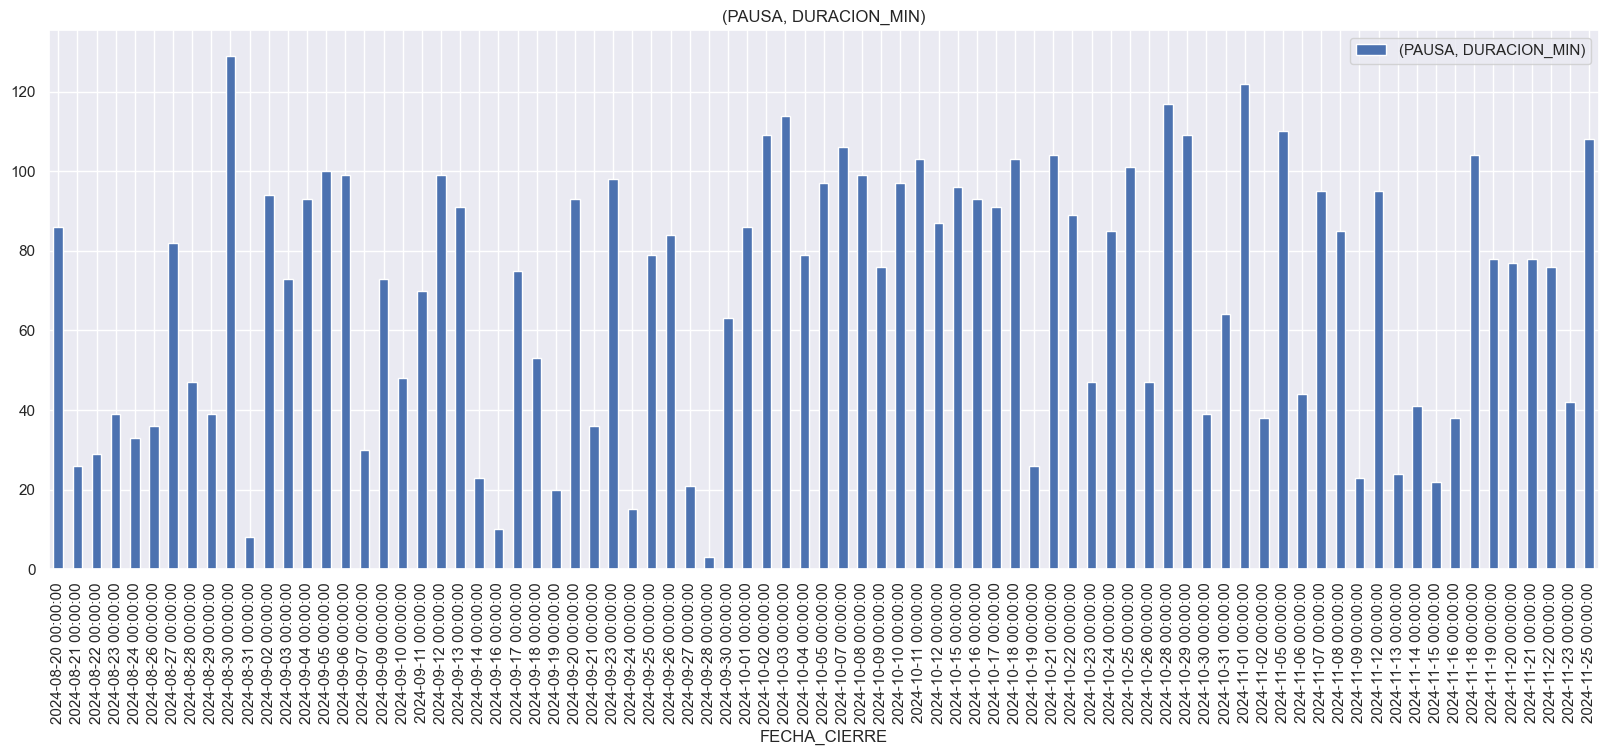

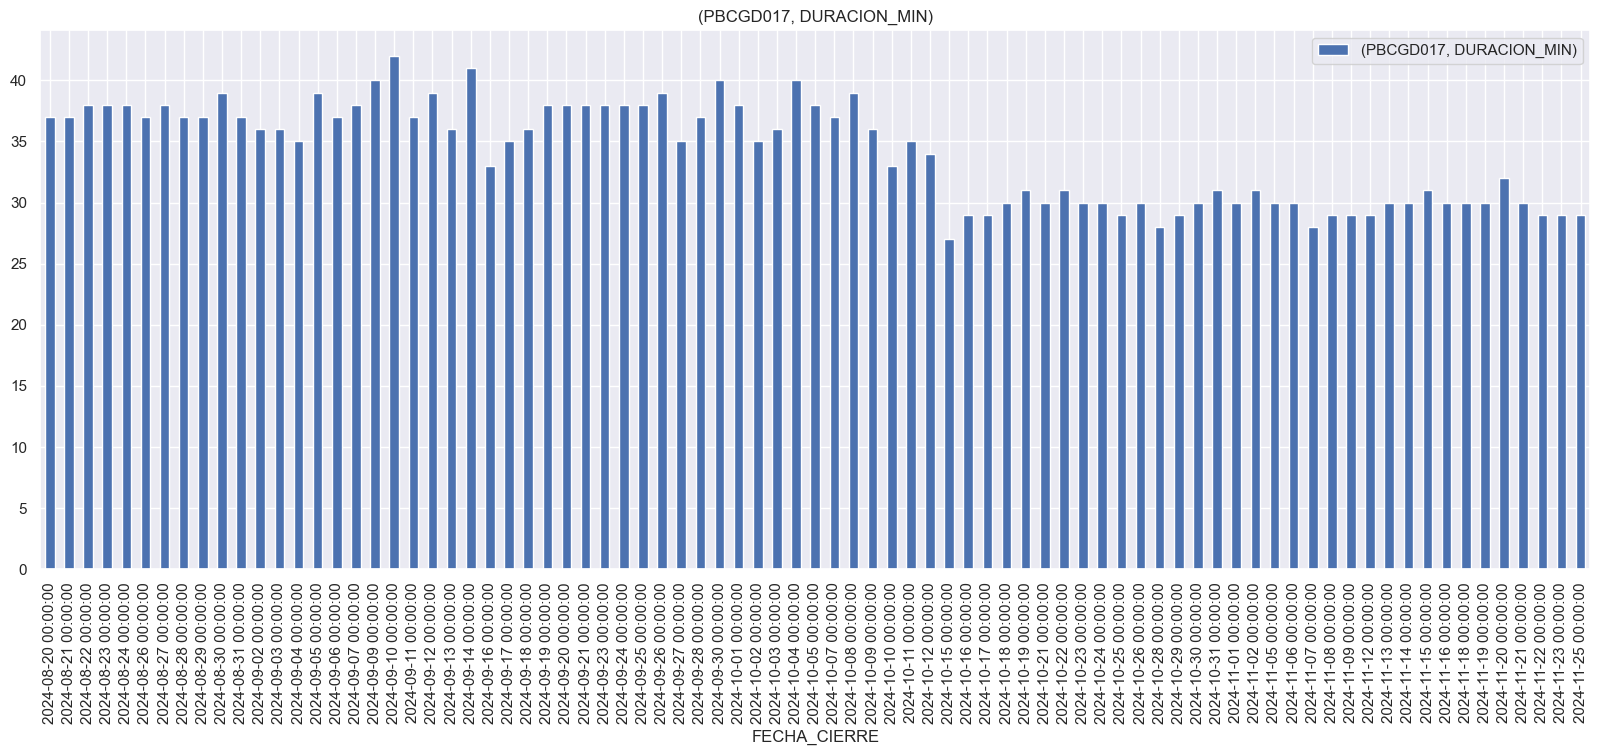

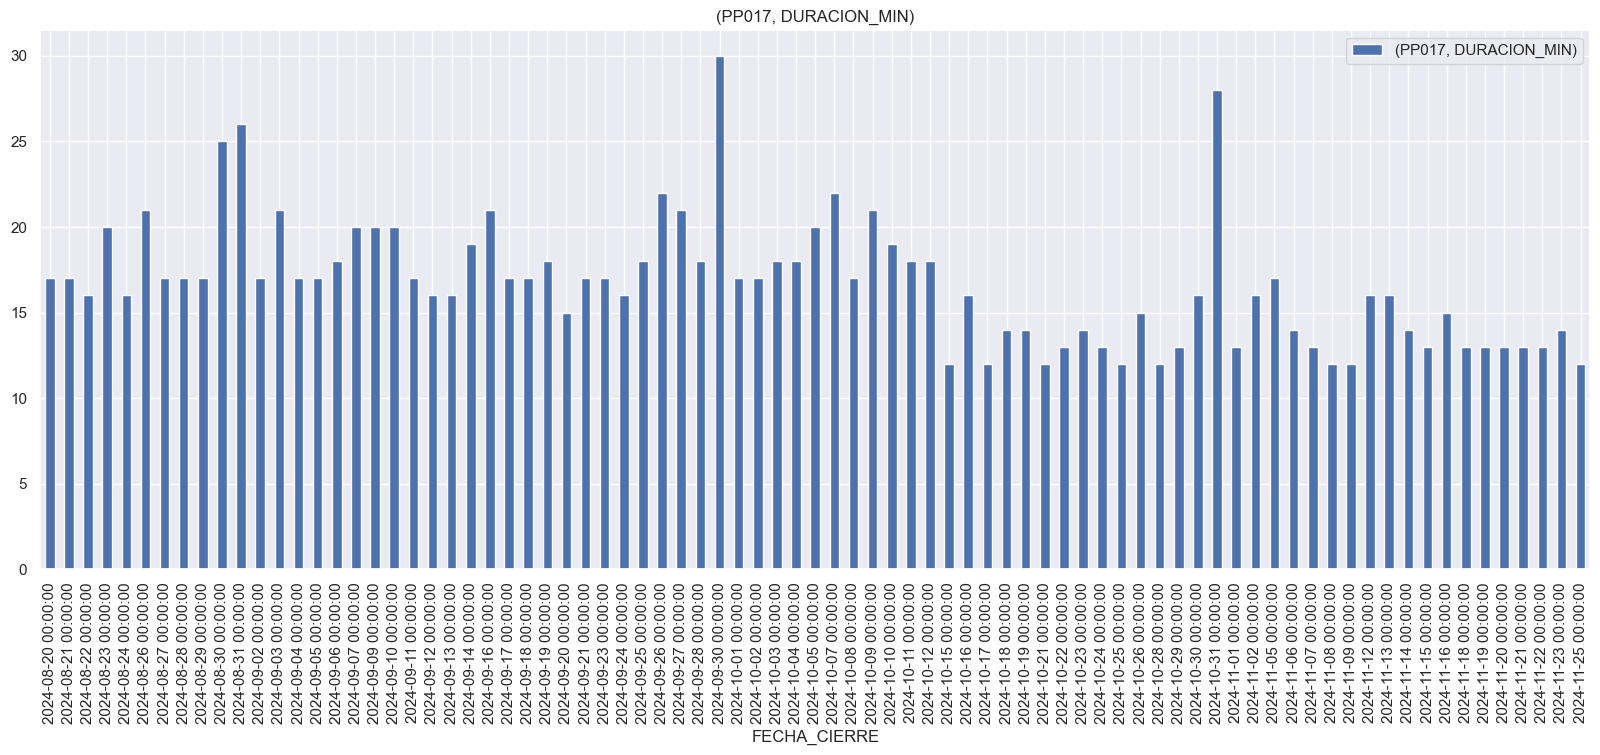

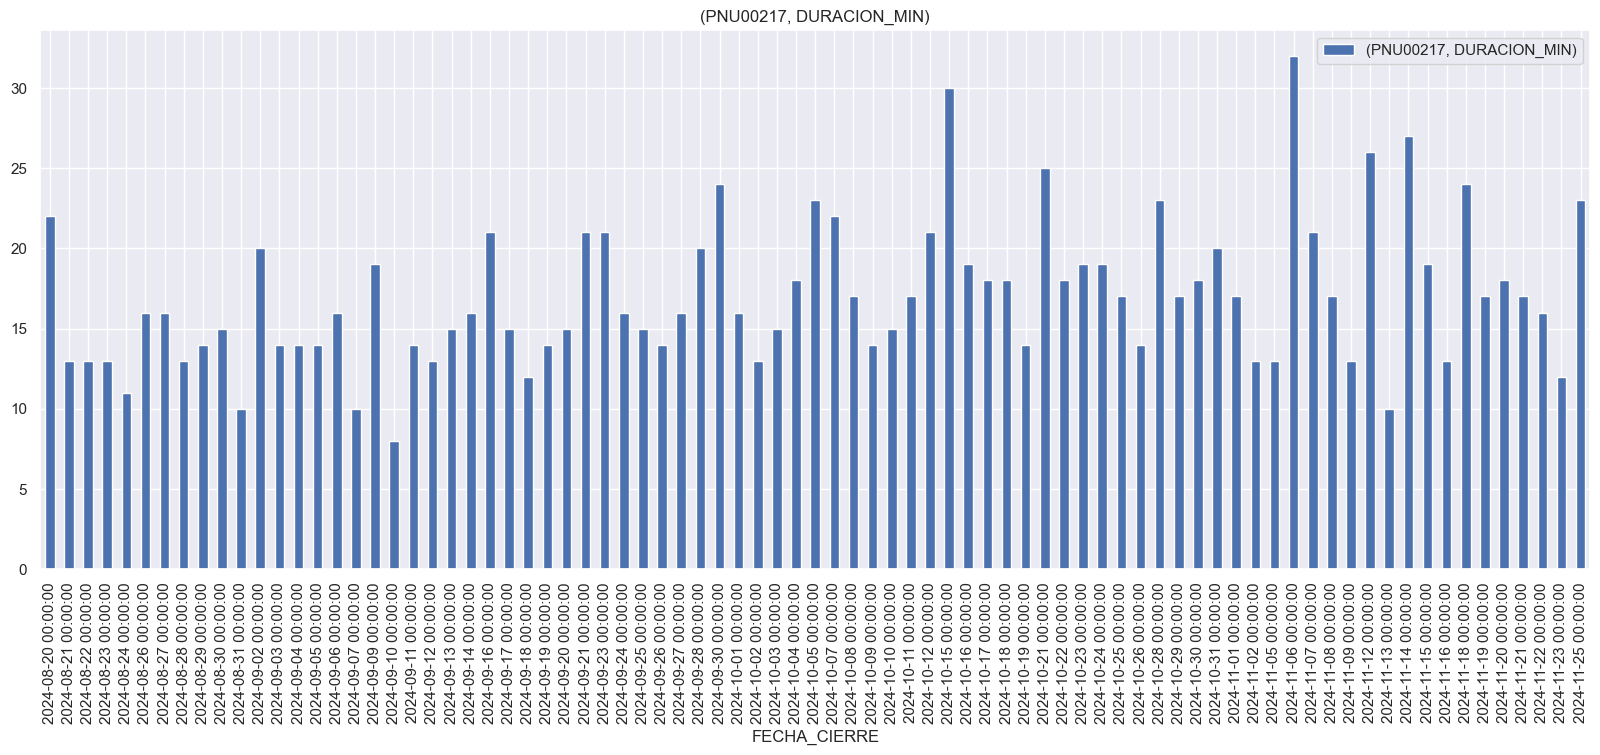

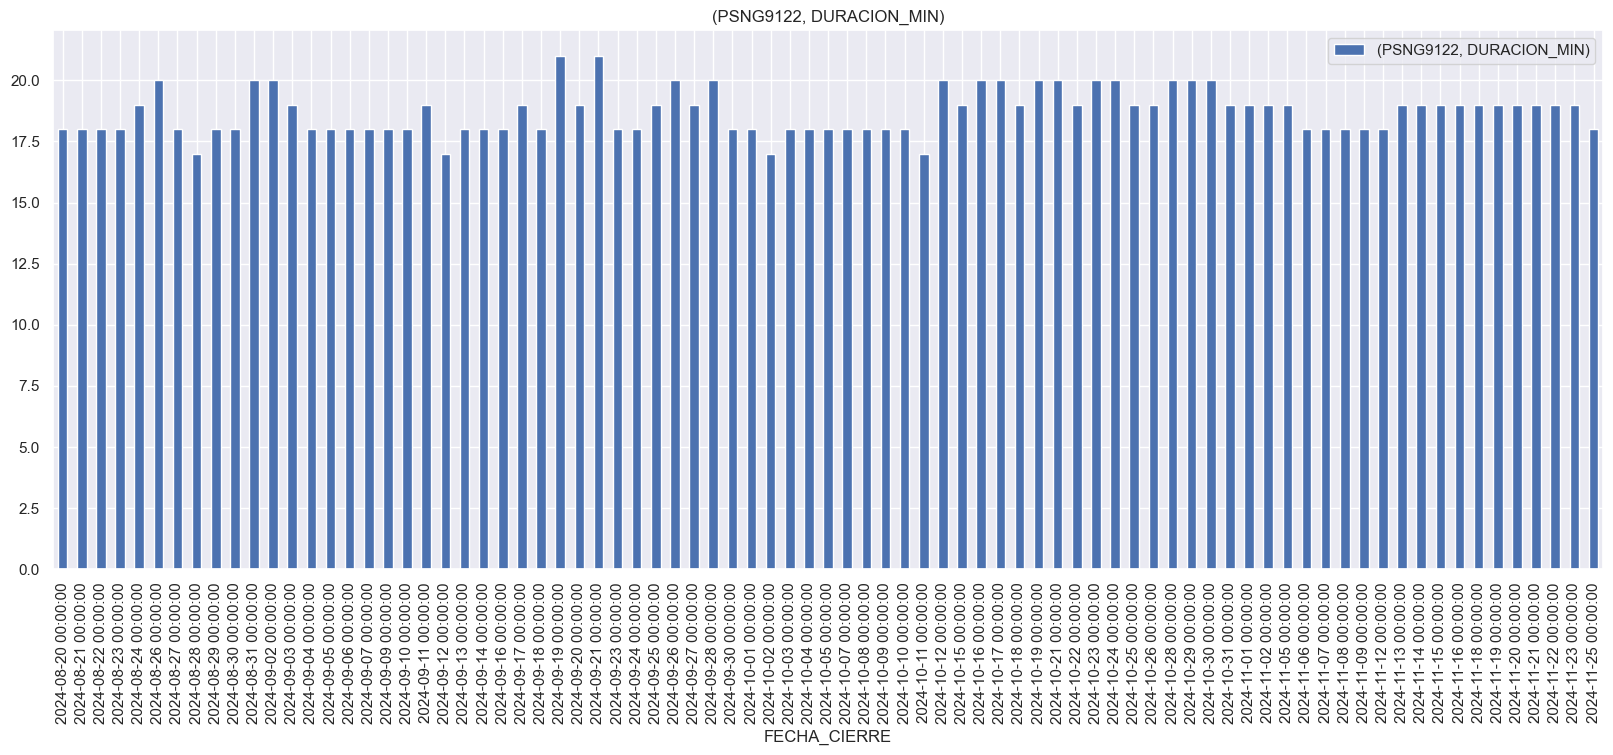

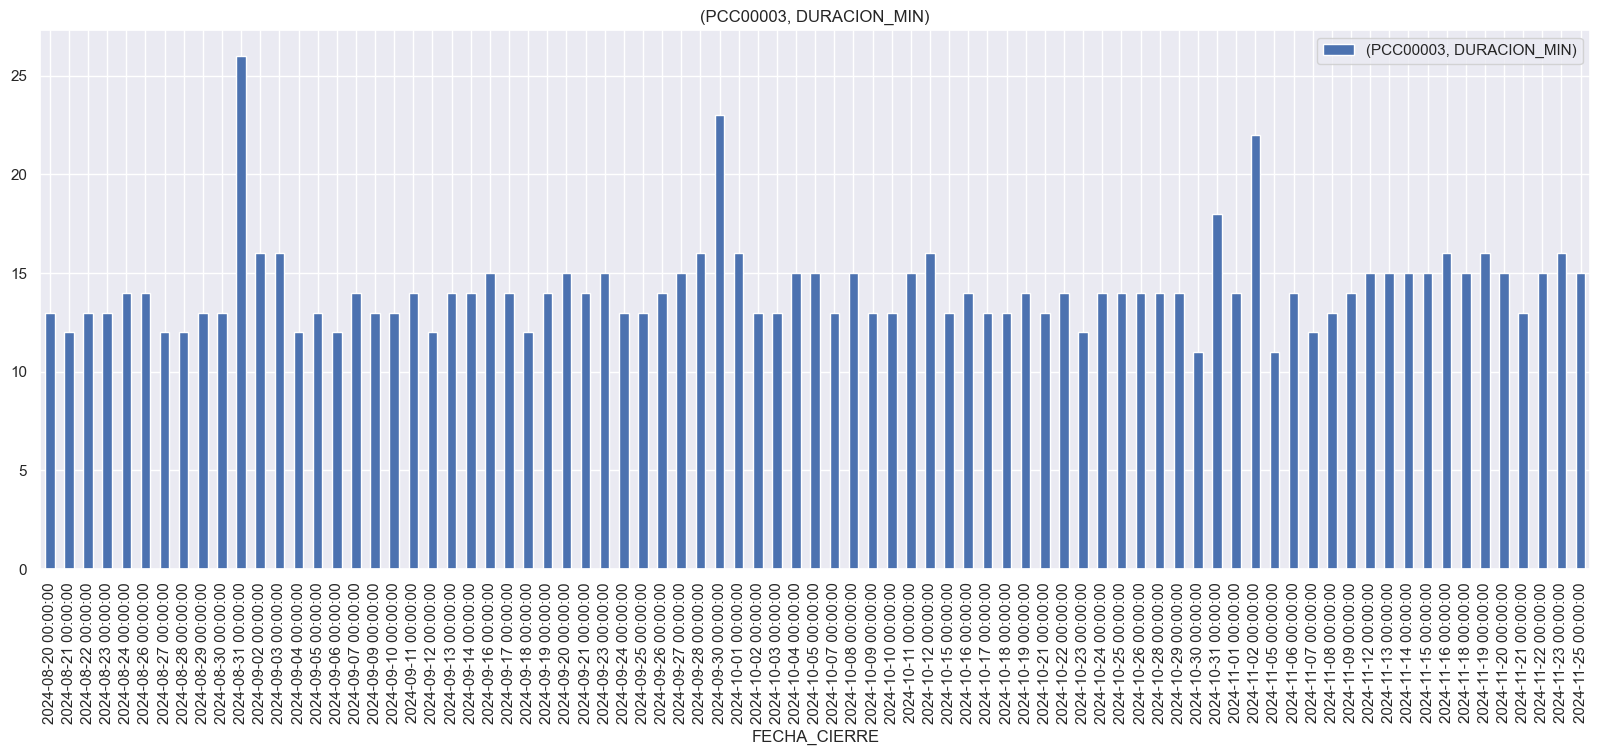

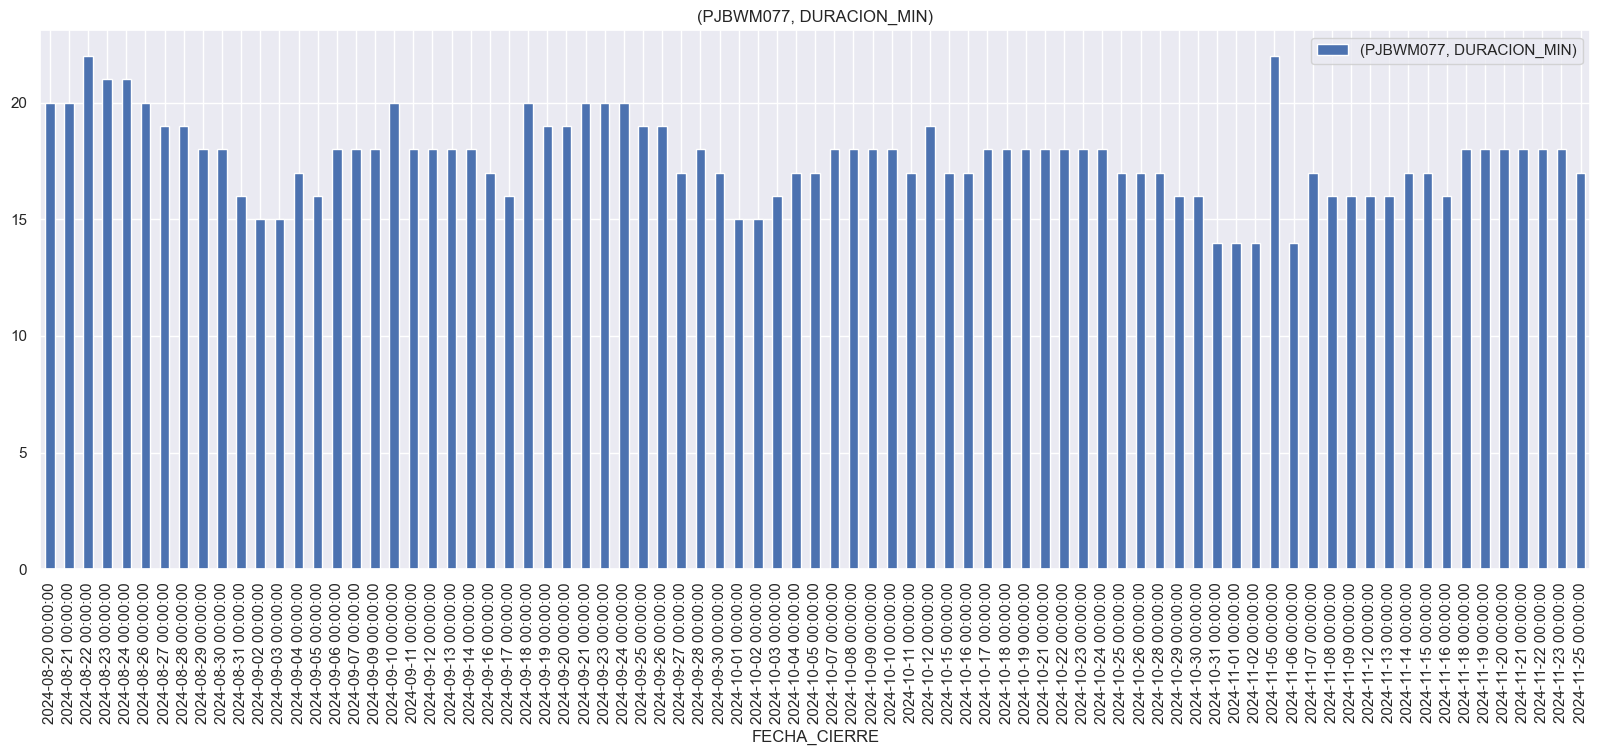

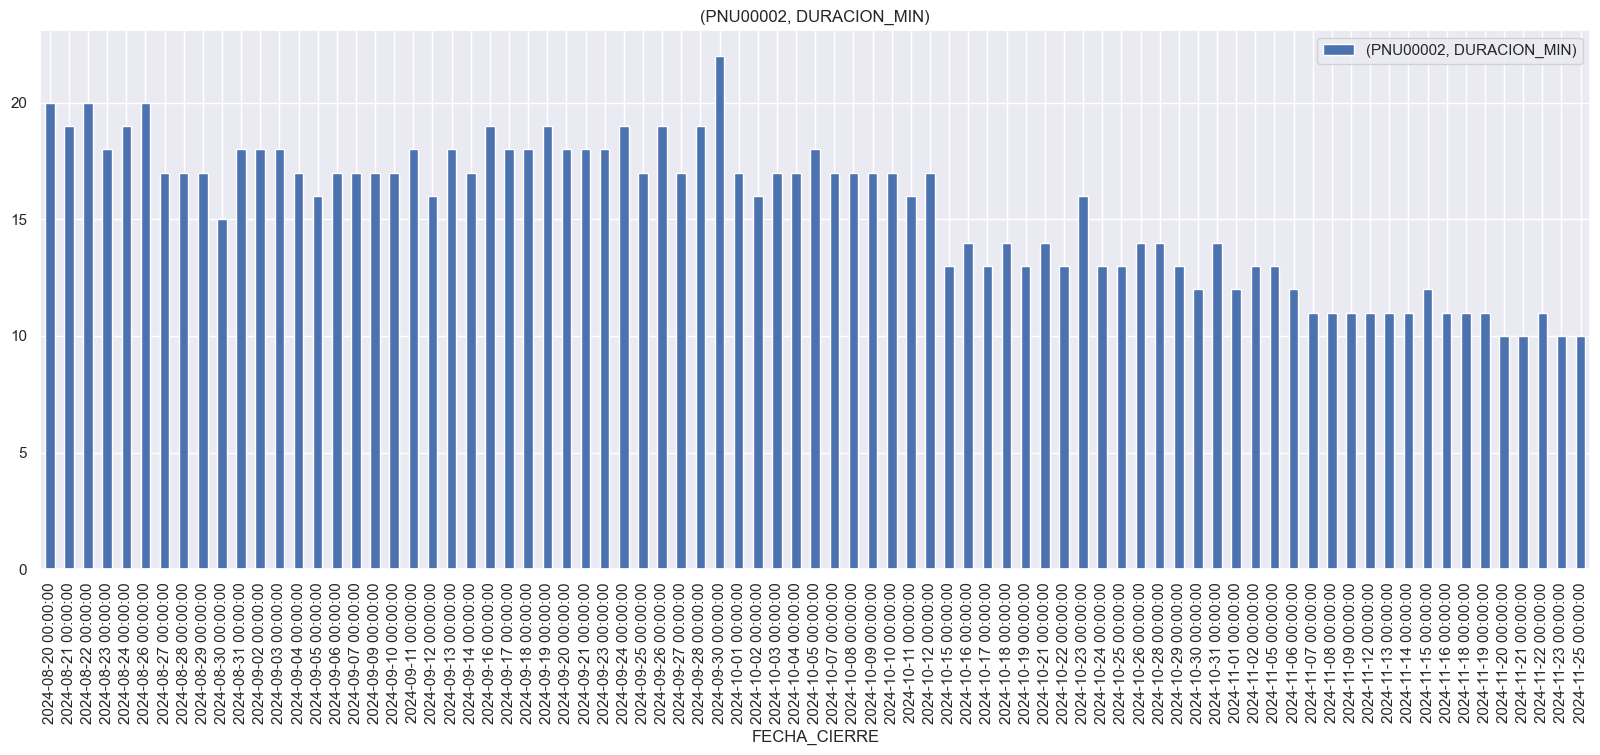

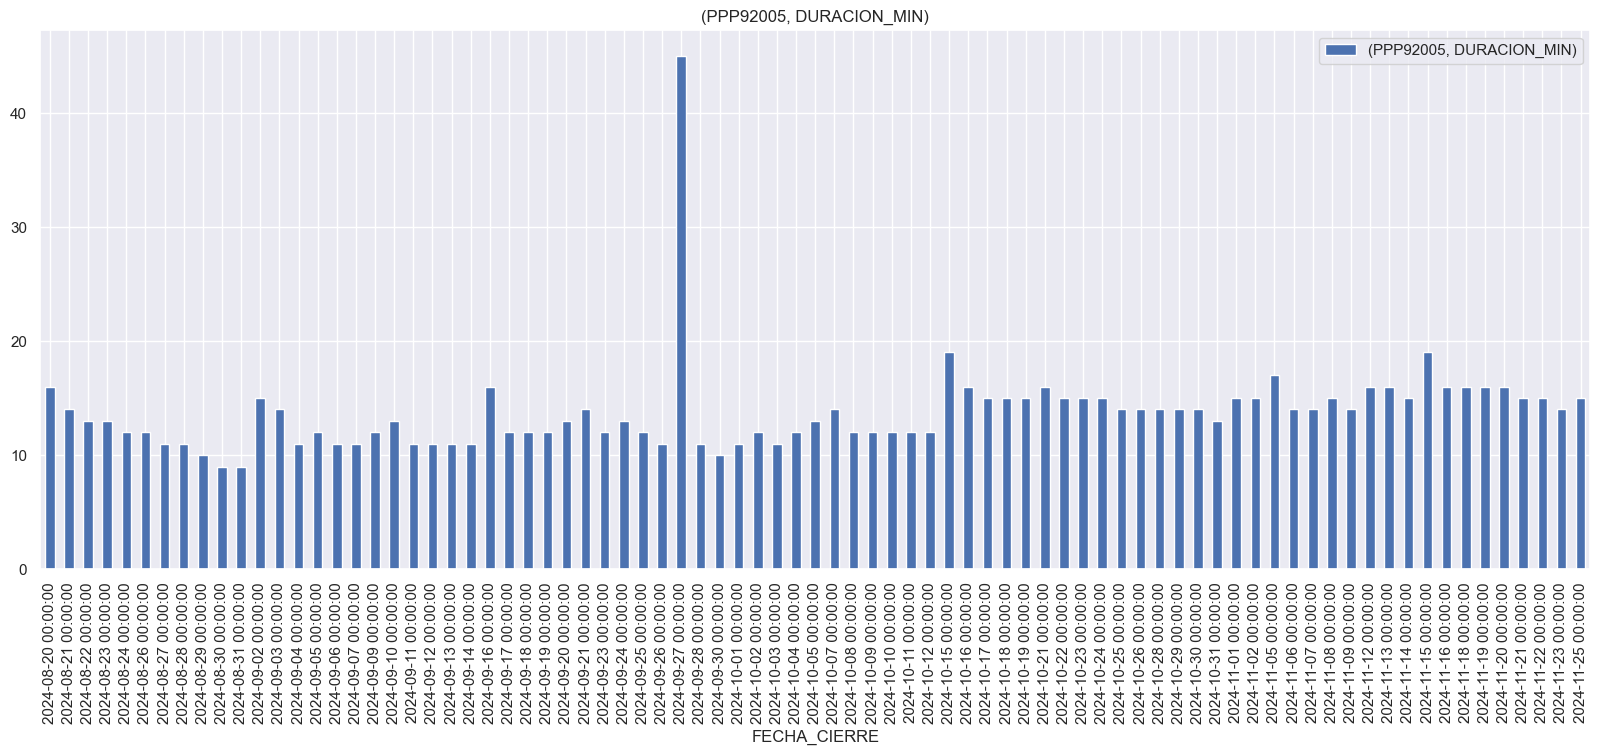

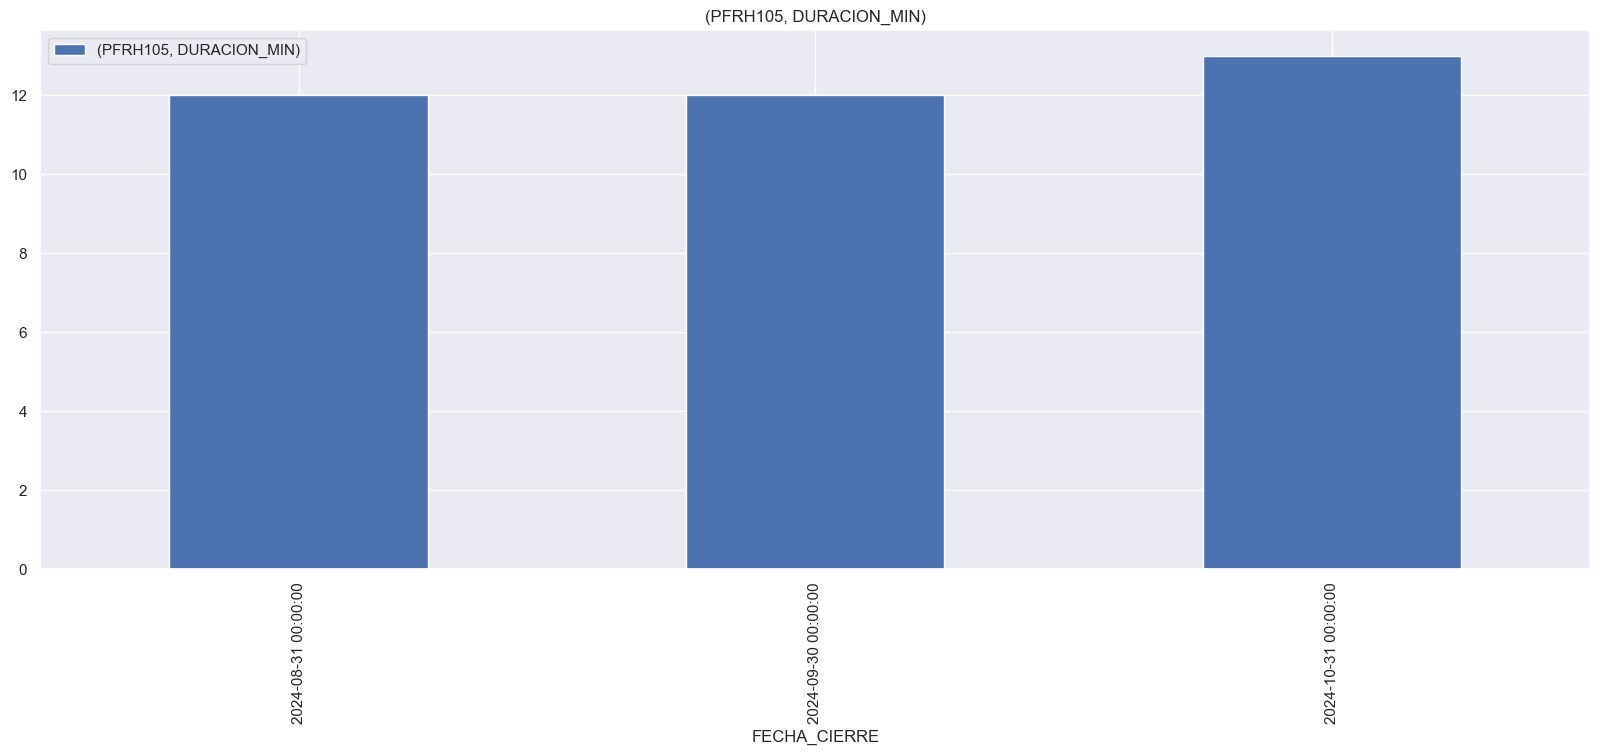

In [65]:
for tarea in lst_oct31:
    df_parcial[df_parcial.CODIGO_TAREA==tarea].groupby(["FECHA_CIERRE",],).max()[["CODIGO_TAREA","DURACION_MIN"]].plot.bar(by="CODIGO_TAREA")

### Número de tareas por fecha

<Axes: xlabel='FECHA_CIERRE'>

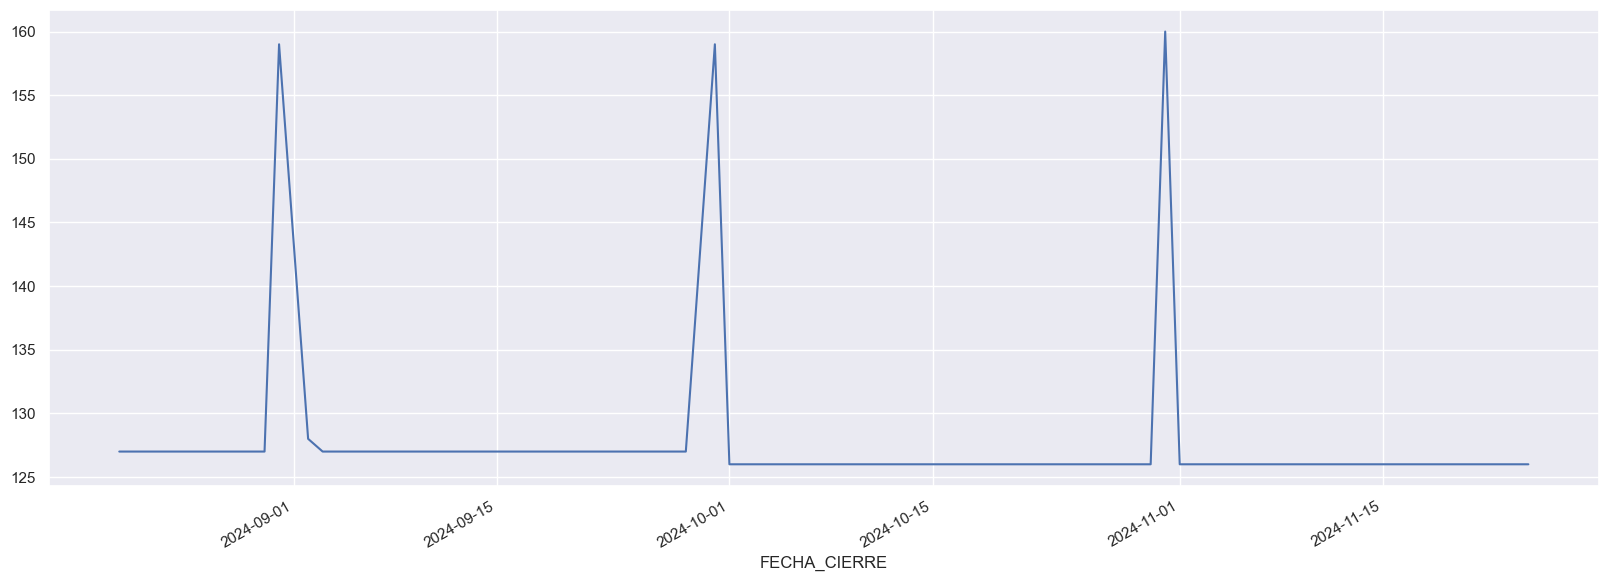

In [66]:
df_parcial.groupby("FECHA_CIERRE").size().plot()

In [68]:
# Ordenar por FECHA y hora de inicio
df_parcial2 = df_parcial.sort_values(by=['FECHA_CIERRE', 'INICIO'])

# Calcular el orden de ejecución de las tareas
df_parcial2['ORDEN'] = df.groupby('FECHA_CIERRE').cumcount() + 1

# Calcular la duración acumulada por fecha
df_parcial2['ACUMULADO_MIN'] = df.groupby('FECHA_CIERRE')['DURACION_MIN'].cumsum()

# Calcular el total de tareas y tiempo total de ejecución por fecha
df_totales = df_parcial2.groupby('FECHA_CIERRE').agg(
    TOTAL_TAREAS=('CODIGO_TAREA', 'count'),
    TIEMPO_TOTAL_MIN=('DURACION_MIN', 'sum')
).reset_index()

# Combinar los totales con el DataFrame original
df_parcial2 = df_parcial2.merge(df_totales, on='FECHA_CIERRE')



In [74]:

df_parcial2[["CODIGO_TAREA","DESCRIPCION_TAREA","DURACION_MIN","ORDEN","TOTAL_TAREAS","ACUMULADO_MIN","TIEMPO_TOTAL_MIN"]][df_parcial2.CODIGO_TAREA.isin(lst_representativas+["PAUSA"])].groupby(["CODIGO_TAREA","DESCRIPCION_TAREA"]).max().sort_values(by="ORDEN")

DURACION_MIN  ORDEN  \
CODIGO_TAREA DESCRIPCION_TAREA                                     
PAUSA        PAUSA Backup Previo                     15.0     32   
PNU00117     Pasaje Resultados FVC                   33.0     62   
PNU00217     Pasaje Resultados M/E a M/N Ac          32.0     63   
PAUSA        Pausa Para Validar La Fecha              4.0     92   
             Pausa monitoreo PBCGD017                 1.0    103   
             PAUSA validar pagos procesados          38.0    104   
             Pausa cargar interfaz SIAD new         122.0    120   
PP020FV2     PASAJE A HISTORICOS DE MOVIMI           59.0    121   
PAUSA        PAUSA Monitoreo proceso tablon           1.0    124   
             PAUSA para cargar pagos                129.0    126   
PP020A       Pasaje a Historico FSH015-16 *          37.0    145   
PAUSA        Validación FSH015 - FSH016              36.0    149   

                                             TOTAL_TAREAS  ACUMULADO_MIN  \
CODIGO_TAREA DESCRIPCION_TAREA                                             
PAUSA        PAUSA Backup Previo                      160           54.0   
PNU00117     Pasaje Resultados FVC                    160          182.0   
PNU00217     Pasaje Resultados M/E a M/N Ac           160          196.0   
PAUSA        Pausa Para Validar La Fecha              128          331.0   
             Pausa monitoreo PBCGD017                 160          217.0   
             PAUSA validar pagos procesados           160          238.0   
             Pausa cargar interfaz SIAD new           160          324.0   
PP020FV2     PASAJE A HISTORICOS DE MOVIMI            160          378.0   
PAUSA        PAUSA Monitoreo proceso tablon           160          289.0   
             PAUSA para cargar pagos                  160          420.0   
PP020A       Pasaje a Historico FSH015-16 *           160          479.0   
PAUSA        Validación FSH015 - FSH016               160          493.0   

                                             TIEMPO_TOTAL_MIN  
CODIGO_TAREA DESCRIPCION_TAREA                                 
PAUSA        PAUSA Backup Previo                        540.0  
PNU00117     Pasaje Resultados FVC                      540.0  
PNU00217     Pasaje Resultados M/E a M/N Ac             540.0  
PAUSA        Pausa Para Validar La Fecha                410.0  
             Pausa monitoreo PBCGD017                   438.0  
             PAUSA validar pagos procesados             540.0  
             Pausa cargar interfaz SIAD new             540.0  
PP020FV2     PASAJE A HISTORICOS DE MOVIMI              540.0  
PAUSA        PAUSA Monitoreo proceso tablon             438.0  
             PAUSA para cargar pagos                    540.0  
PP020A       Pasaje a Historico FSH015-16 *             540.0  
PAUSA        Validación FSH015 - FSH016                 540.0